# Skin Cancer Data Analysis


## 1. Setup and Imports

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from dython.nominal import associations
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import mutual_info_classif, chi2, SelectKBest, RFE
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.decomposition import PCA

# Set plotting style
sns.set_style('whitegrid')


## 2. Utility Functions


In [ ]:
def find_col_name(df, keywords):
    for col in df.columns:
        # Normalize column name 
        normalized_col = col.lower().replace('_', ' ')
        if all(keyword.lower() in normalized_col for keyword in keywords):
            return col
    return None


def balanced_split(X, y, test_size=0.2, random_state=42):
    np.random.seed(random_state)
    unique_classes, y_indices = np.unique(y, return_inverse=True)
    test_idx = []
    train_idx = []

    for c in range(len(unique_classes)):
        class_idx = np.where(y_indices == c)[0]
        class_idx = shuffle(class_idx, random_state=random_state)
        n_test = int(np.ceil(len(class_idx) * test_size))
        test_idx.extend(class_idx[:n_test])
        train_idx.extend(class_idx[n_test:])

    return np.array(train_idx), np.array(test_idx)


## 3. Data Loading and Initial Exploration


In [19]:
# Load the dataset
file_path = 'Data/skin cancer data_transformed_2_classes.csv'
df = pd.read_csv(file_path)

# Display the first few rows
print("First 5 rows of the dataset:")
display(df.head())

# Display basic info and statistics
print("\nDataFrame Info:")
df.info()

print("\nDescriptive Statistics:")
display(df.describe())


First 5 rows of the dataset:


,Code,sex,age,marital,career,residence,income,exercise,tobacco,meat,...,tumor size,tumor depth,origin site,margin,chemotherapy,radiotherapy,appearance,surgery,expire,recurrency
0,1,1,54,1,8,1,3,1,2,1,...,3.0,0.2,3,3,2,2,4,1,2,2
1,2,1,47,1,3,1,3,2,2,1,...,5.0,1.3,11,3,2,2,2,1,2,2
2,3,1,71,1,1,2,2,2,1,2,...,5.0,2.5,5,2,2,2,2,1,1,1
3,4,2,84,1,5,1,3,1,2,1,...,4.0,0.3,5,3,2,2,4,1,2,2
4,5,2,57,1,5,1,3,1,2,1,...,2.0,0.2,3,3,2,2,4,1,2,2



DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1064 entries, 0 to 1063
Data columns (total 34 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Code          1064 non-null   int64  
 1   sex           1064 non-null   int64  
 2   age           1064 non-null   int64  
 3   marital       1064 non-null   int64  
 4   career        1064 non-null   int64  
 5   residence     1064 non-null   int64  
 6   income        1064 non-null   int64  
 7   exercise      1064 non-null   int64  
 8   tobacco       1064 non-null   int64  
 9   meat          1064 non-null   int64  
 10  dairy         1064 non-null   int64  
 11  fruit         1064 non-null   int64  
 12  vegetable     1064 non-null   int64  
 13  cereal        1064 non-null   int64  
 14  sunscreen     1064 non-null   int64  
 15  DM            1064 non-null   int64  
 16  HTN           1064 non-null   int64  
 17  vascular dx   1064 non-null   int64  
 18  immune dx  

,Code,sex,age,marital,career,residence,income,exercise,tobacco,meat,...,tumor size,tumor depth,origin site,margin,chemotherapy,radiotherapy,appearance,surgery,expire,recurrency
count,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,...,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000
mean,532.500000,1.459586,60.724624,1.061090,5.077068,1.277256,2.104323,2.014098,1.642857,1.707707,...,8.981579,1.529887,5.504699,2.426692,1.945489,1.944549,2.946429,1.005639,1.864662,1.815789
std,307.294647,0.498598,17.344561,0.239608,2.051932,0.447854,0.798293,0.739167,0.479383,0.588457,...,8.377655,1.452364,3.935507,0.796442,0.227131,0.228966,0.949301,0.074917,0.342245,0.387838
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.300000,0.100000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,266.750000,1.000000,50.000000,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,3.600000,0.600000,3.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000
50%,532.500000,1.000000,63.000000,1.000000,5.000000,1.000000,2.000000,2.000000,2.000000,2.000000,...,6.000000,1.100000,5.000000,3.000000,2.000000,2.000000,3.000000,1.000000,2.000000,2.000000
75%,798.250000,2.000000,73.000000,1.000000,6.000000,2.000000,3.000000,3.000000,2.000000,2.000000,...,11.000000,2.000000,7.000000,3.000000,2.000000,2.000000,4.000000,1.000000,2.000000,2.000000
max,1064.000000,2.000000,96.000000,2.000000,8.000000,2.000000,3.000000,3.000000,2.000000,3.000000,...,67.500000,16.000000,17.000000,3.000000,2.000000,2.000000,6.000000,2.000000,2.000000,2.000000


## 4. Missing Data Handling

In [ ]:
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({'Missing Values': missing_values, 'Percentage (%)': missing_percent})
missing_df = missing_df[missing_df['Missing Values'] > 0].sort_values(by='Percentage (%)', ascending=False)

if missing_df.empty:
    print("No missing values found.")
else:
    print("Missing Data Report:")
    display(missing_df)

    # Visualize missing data
    plt.figure(figsize=(12, 8))
    sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
    plt.title('Heatmap of Missing Data')
    plt.show()

# Implement Imputation 
df_clean = df.copy()
if not missing_df.empty:
    print("\nImplementing imputation strategy...")
    cols_with_missing = missing_df.index
    categorical_cols = df_clean[cols_with_missing].select_dtypes(include='object').columns
    numerical_cols = df_clean[cols_with_missing].select_dtypes(include=np.number).columns

    for col in categorical_cols:
        mode_val = df_clean[col].mode()[0]
        df_clean[col].fillna(mode_val, inplace=True)

    for col in numerical_cols:
        median_val = df_clean[col].median()
        df_clean[col].fillna(median_val, inplace=True)

# Verify that there are no more missing values
print("\nMissing values count after handling:", df_clean.isnull().sum().sum())


No missing values found.

Missing values count after handling: 0


## 5. Exploratory Data Analysis (EDA)


--- Running Univariate Analysis ---
Numerical columns for EDA: ['age', 'tumor size', 'tumor depth']
Excluded from EDA (identified as codes/IDs): ['Code']

Distribution of Numerical Features:


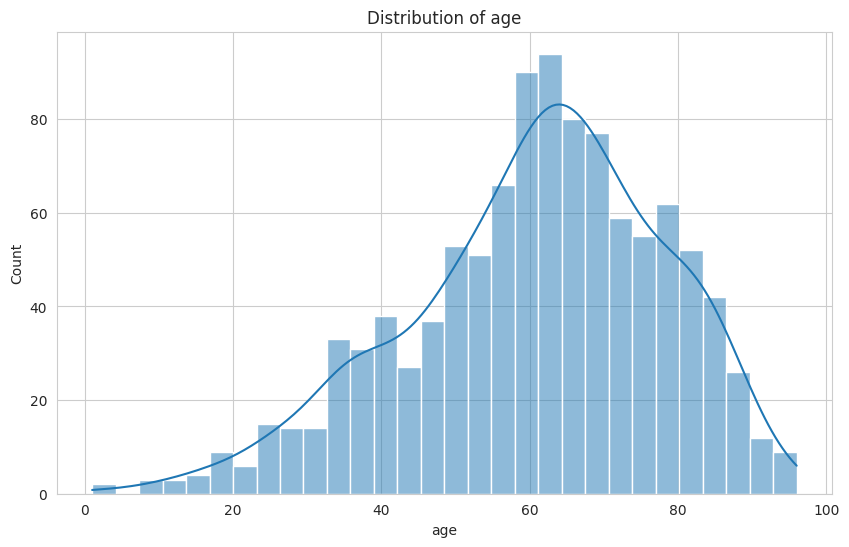

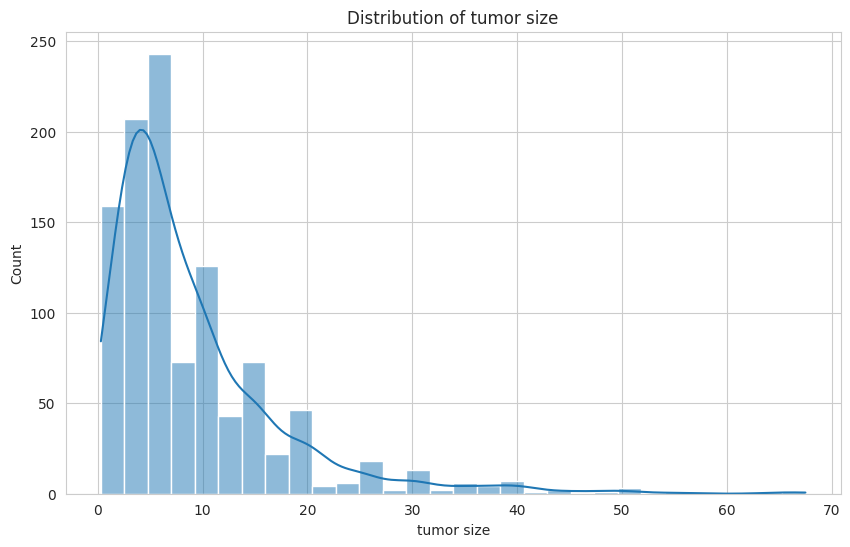

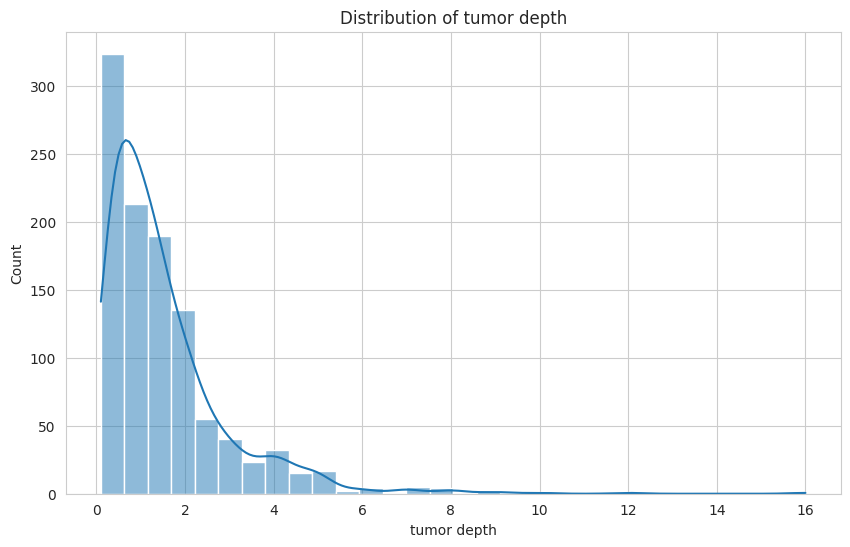


Distribution of Categorical Features:


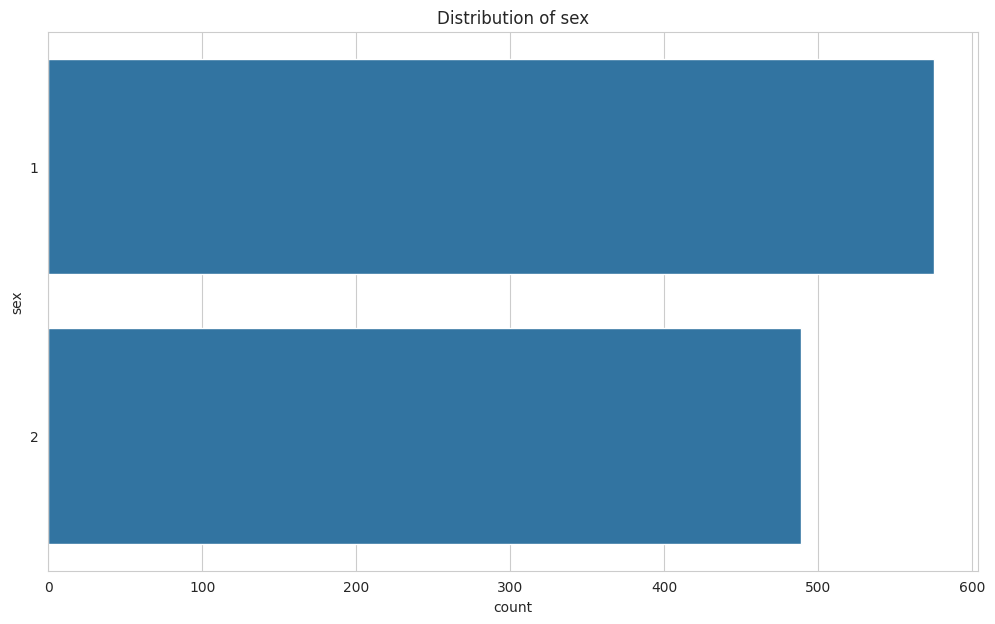

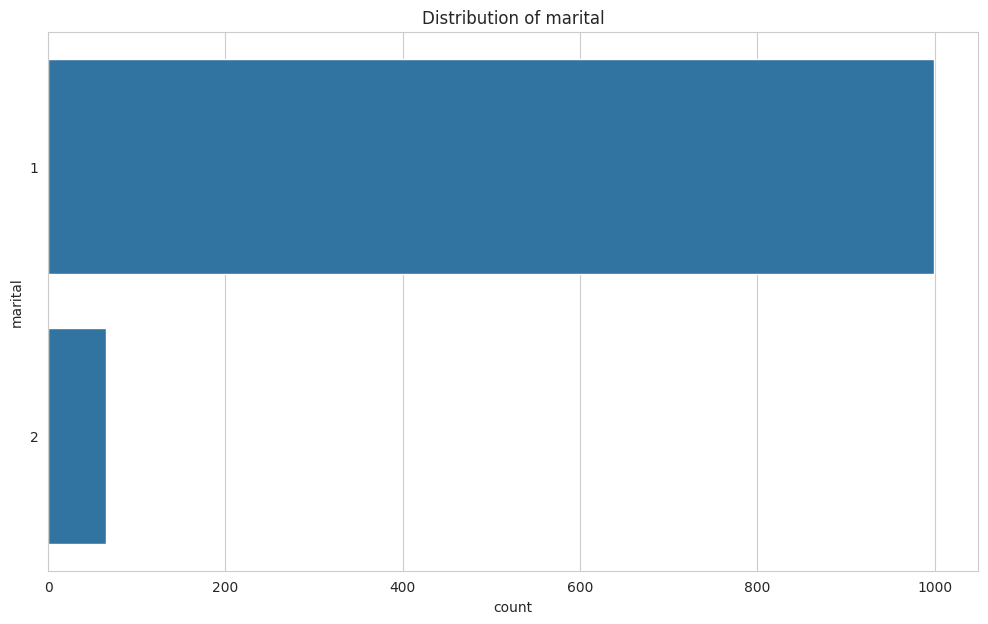

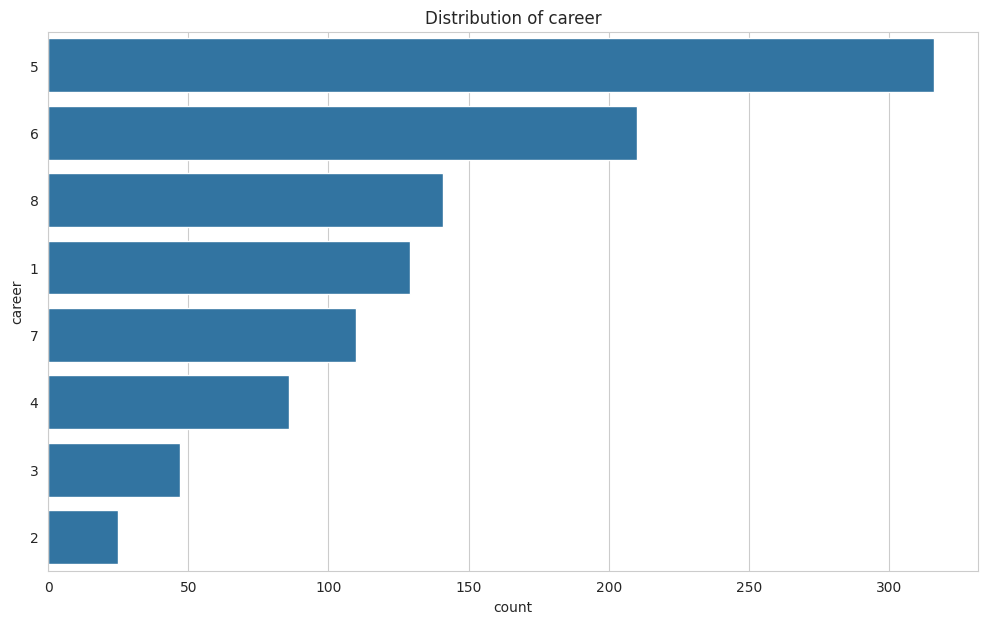

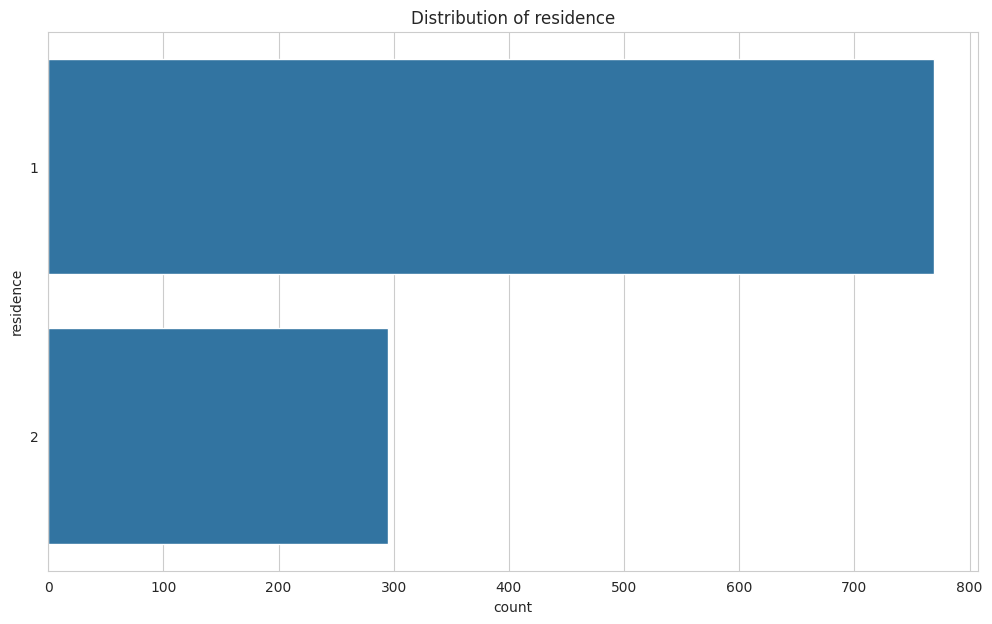

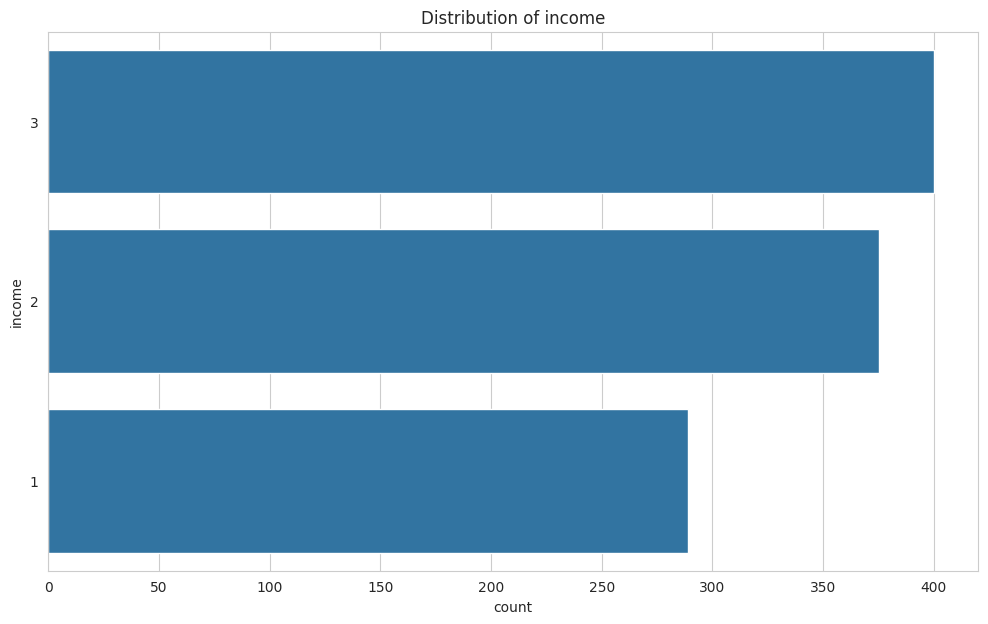

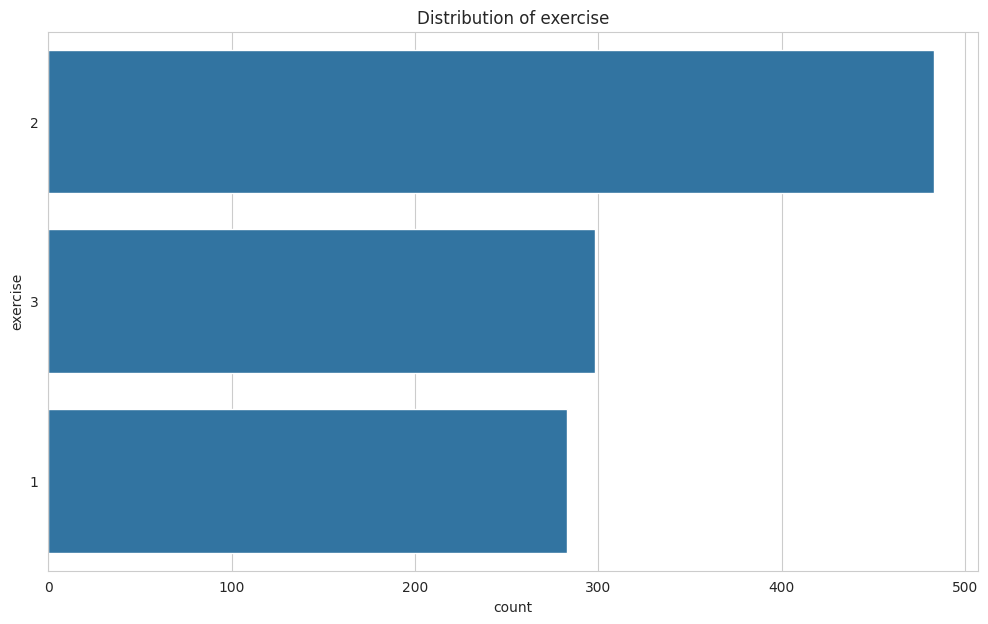

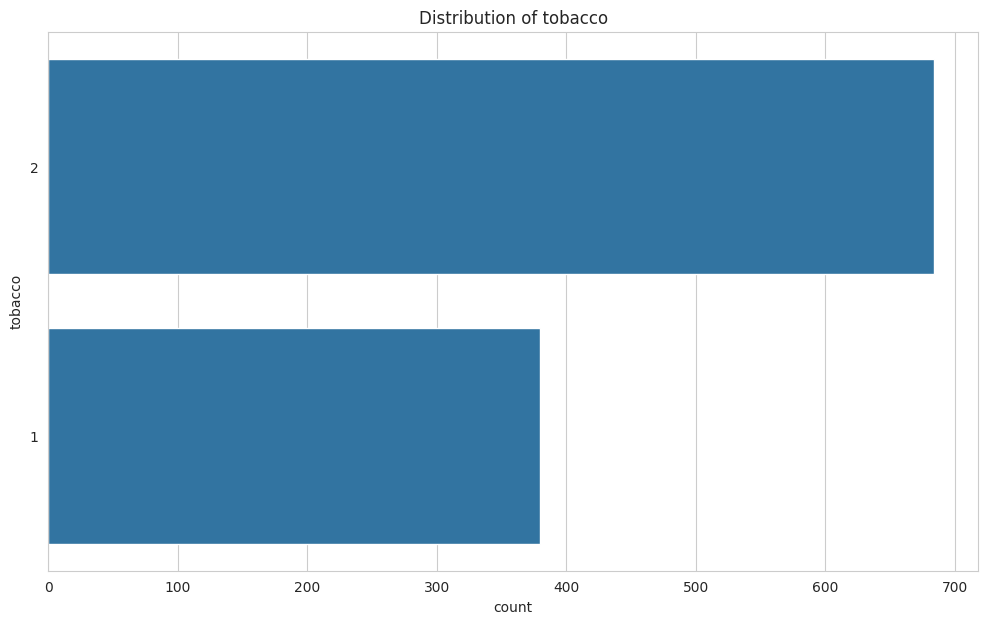

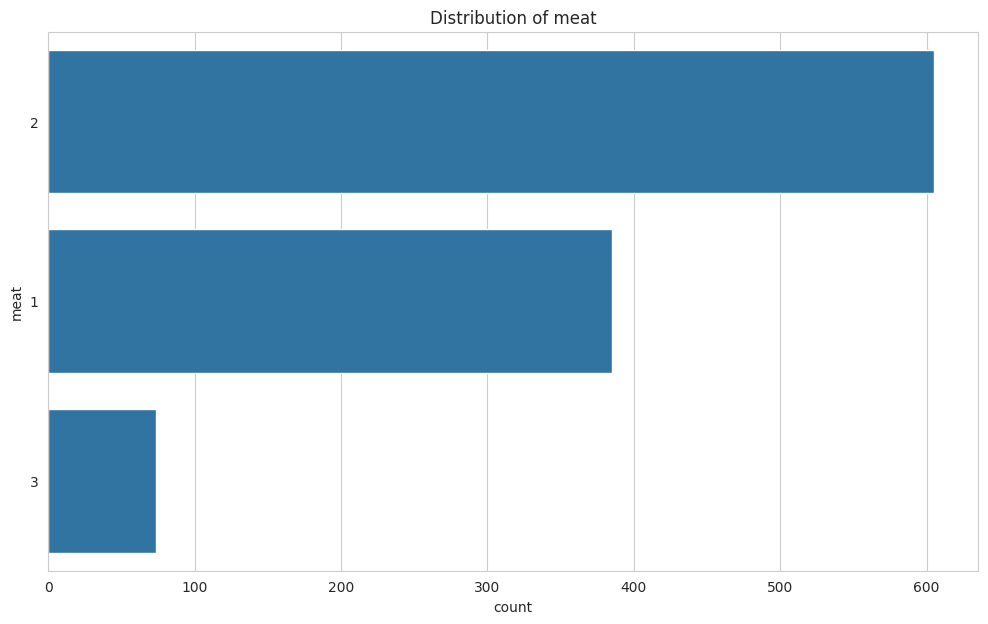

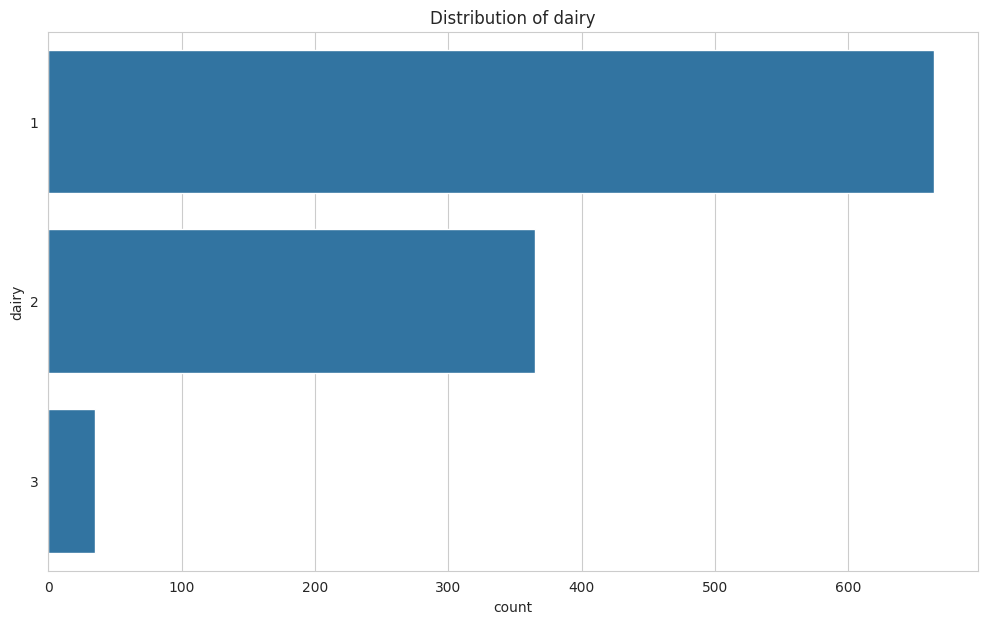

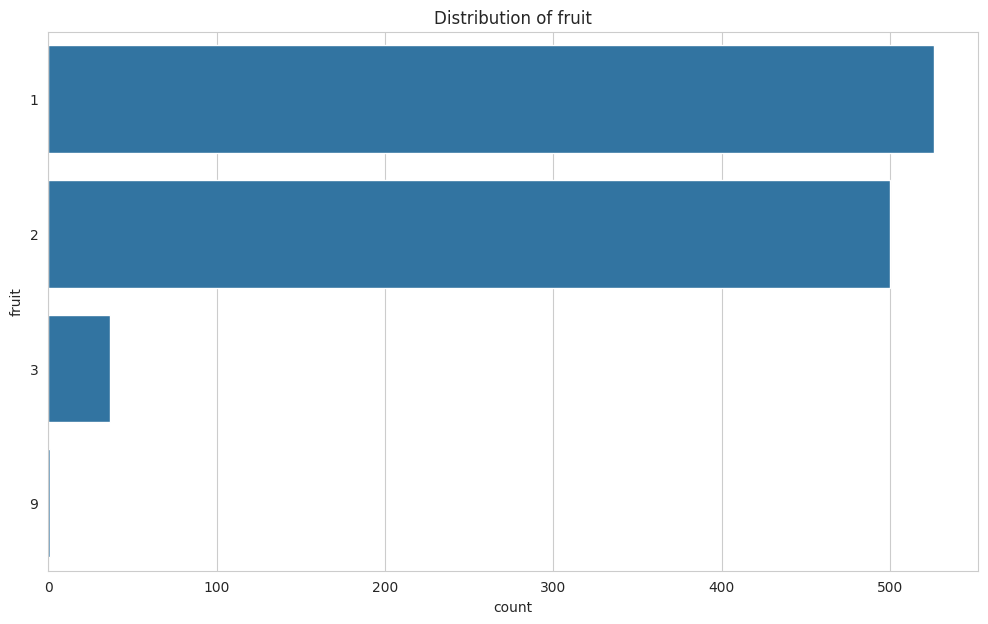

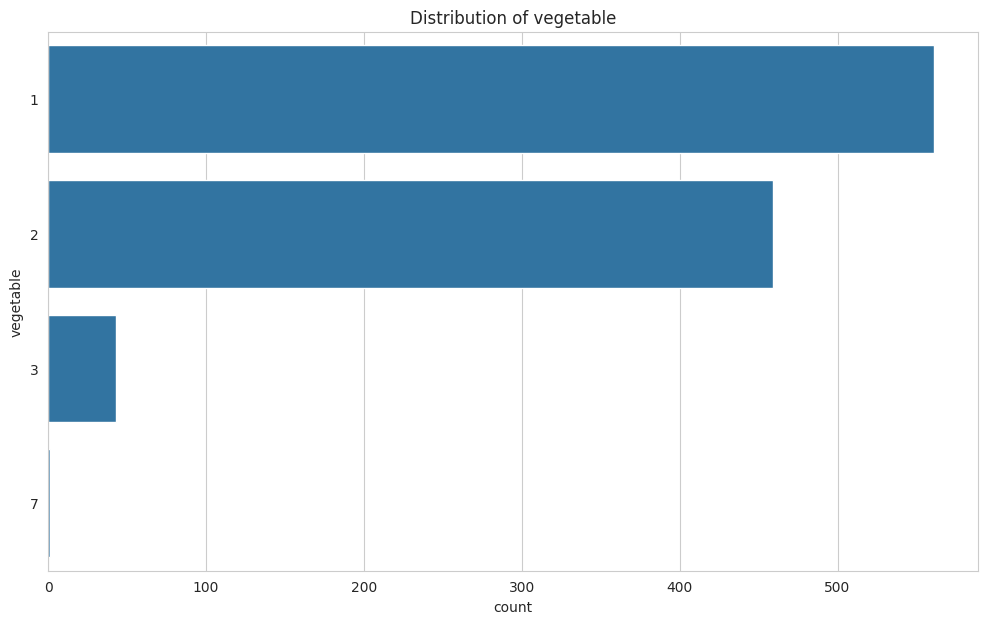

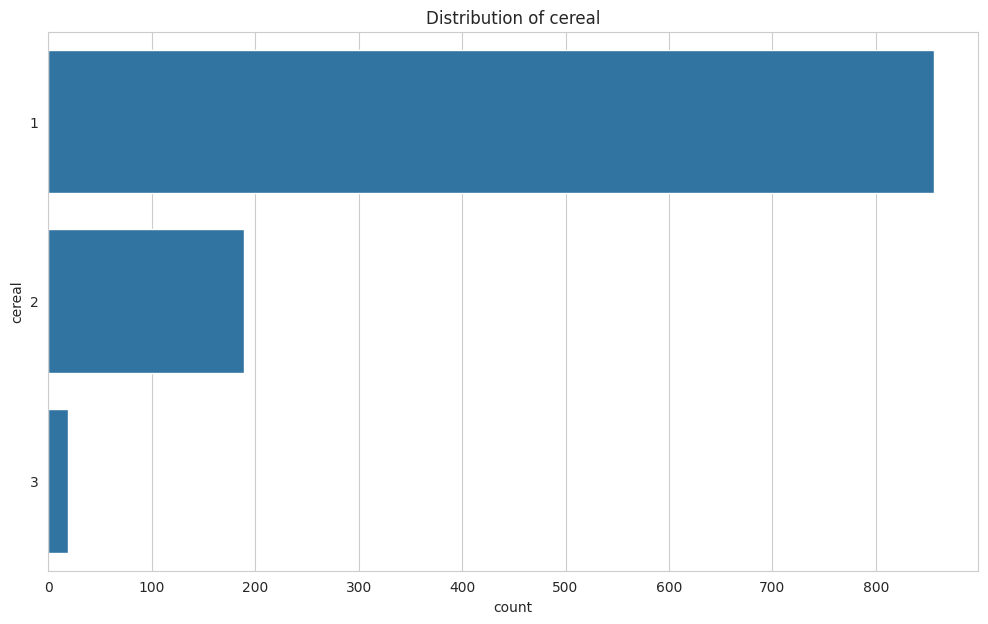

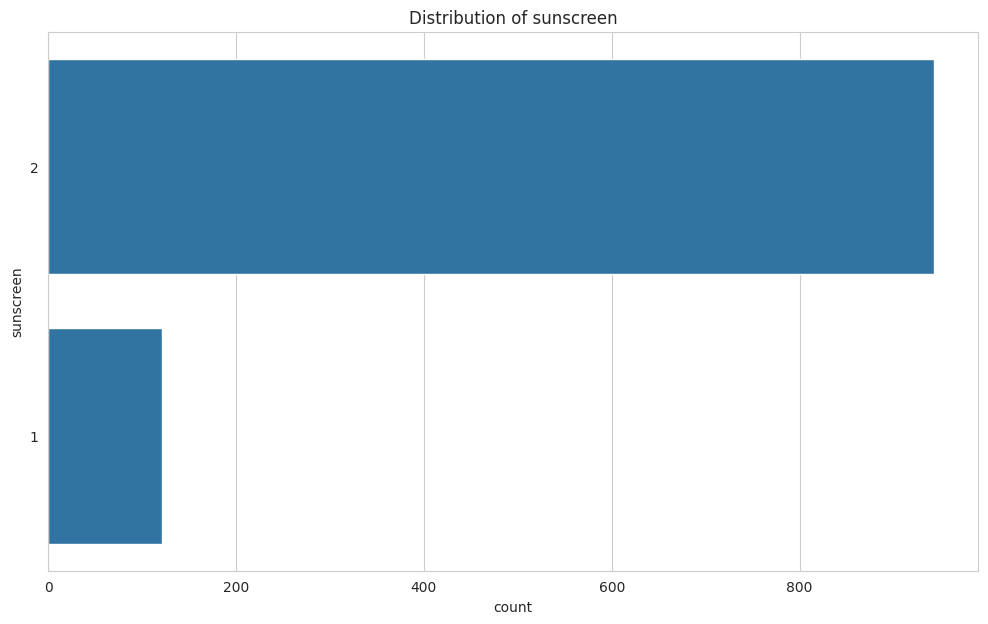

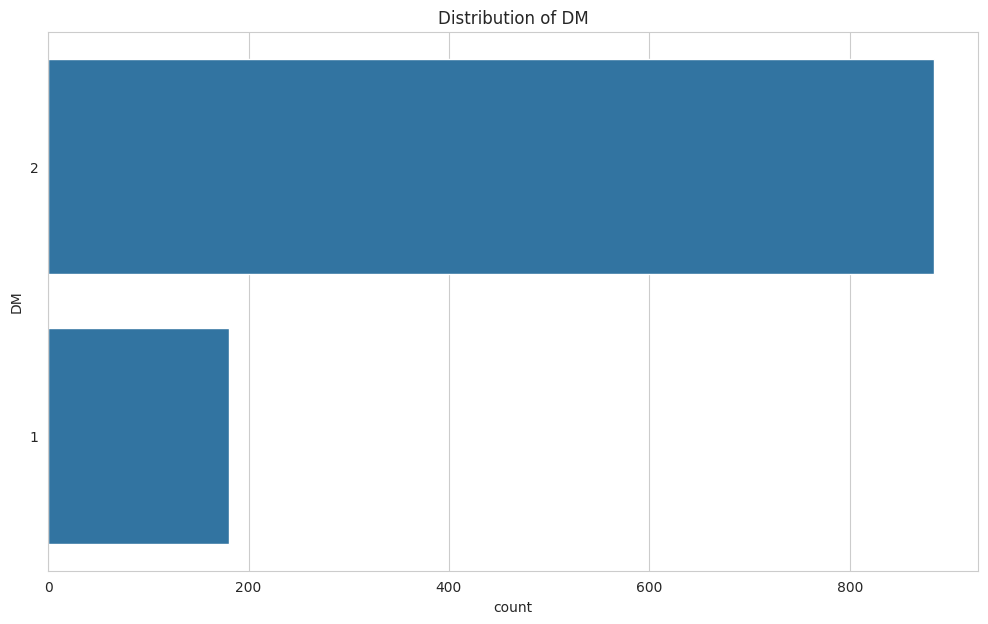

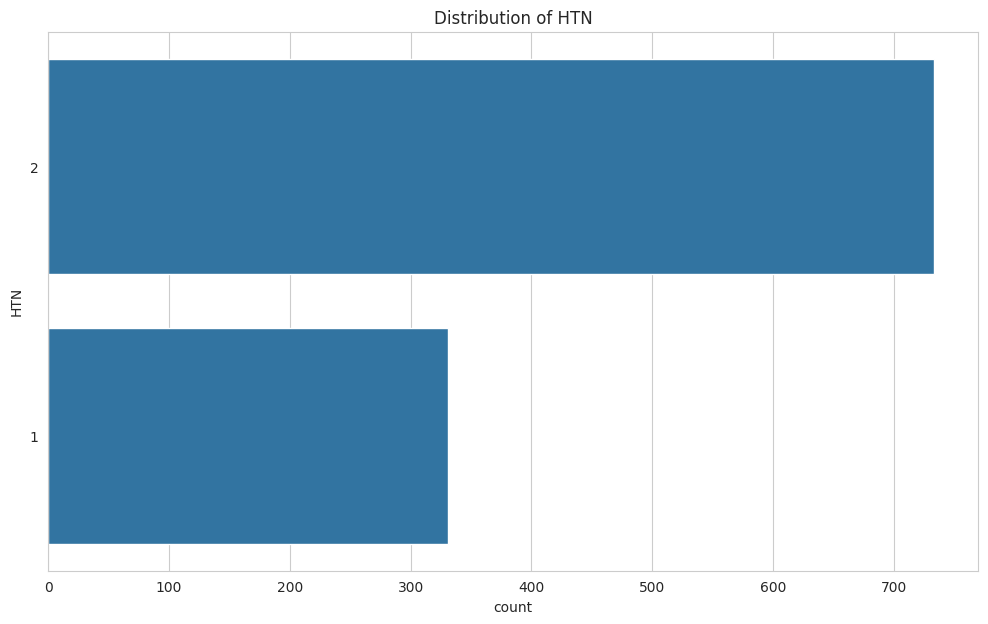

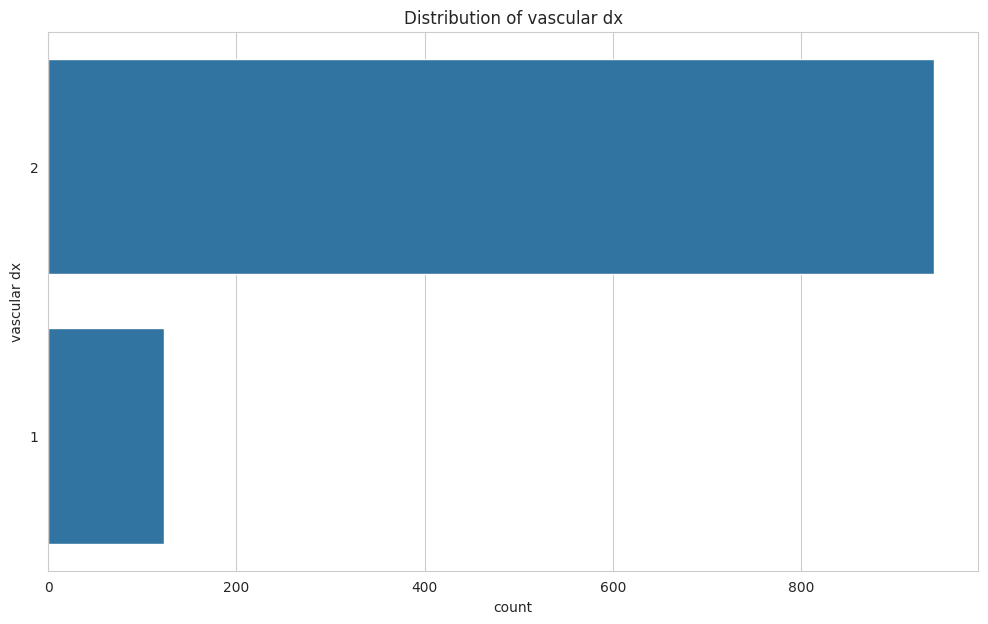

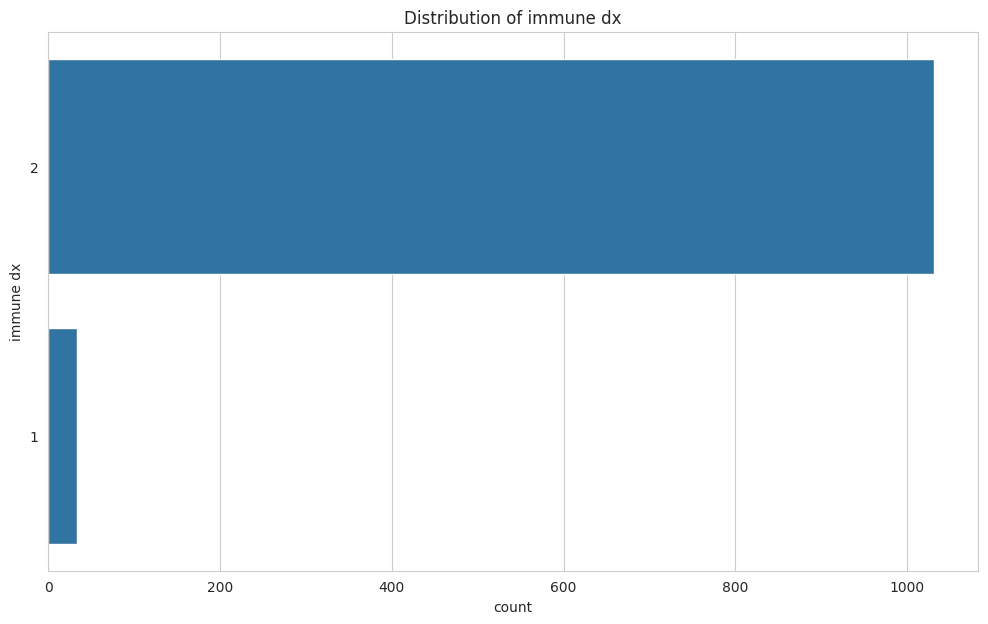

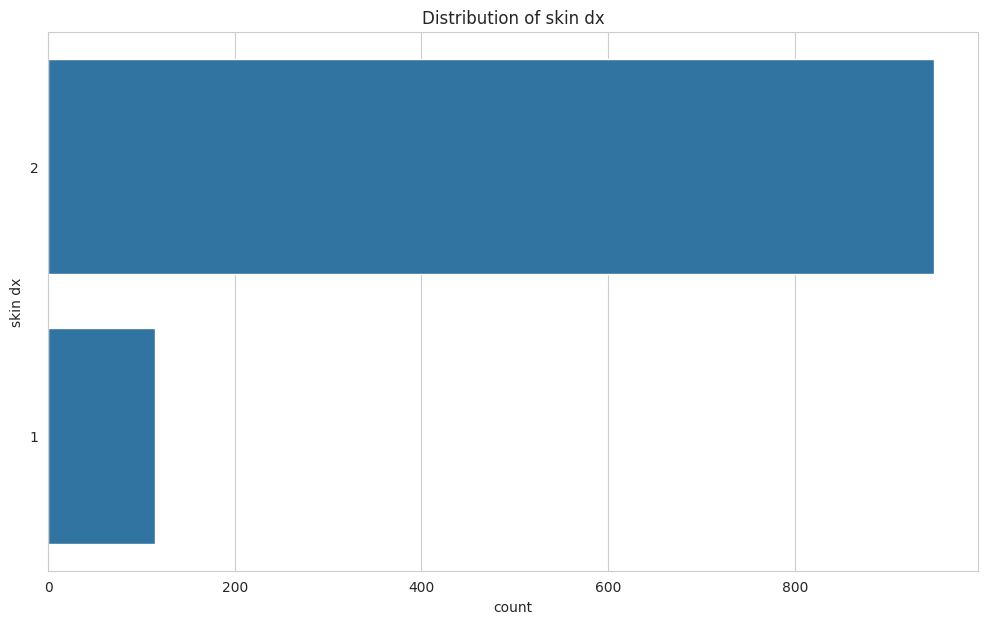

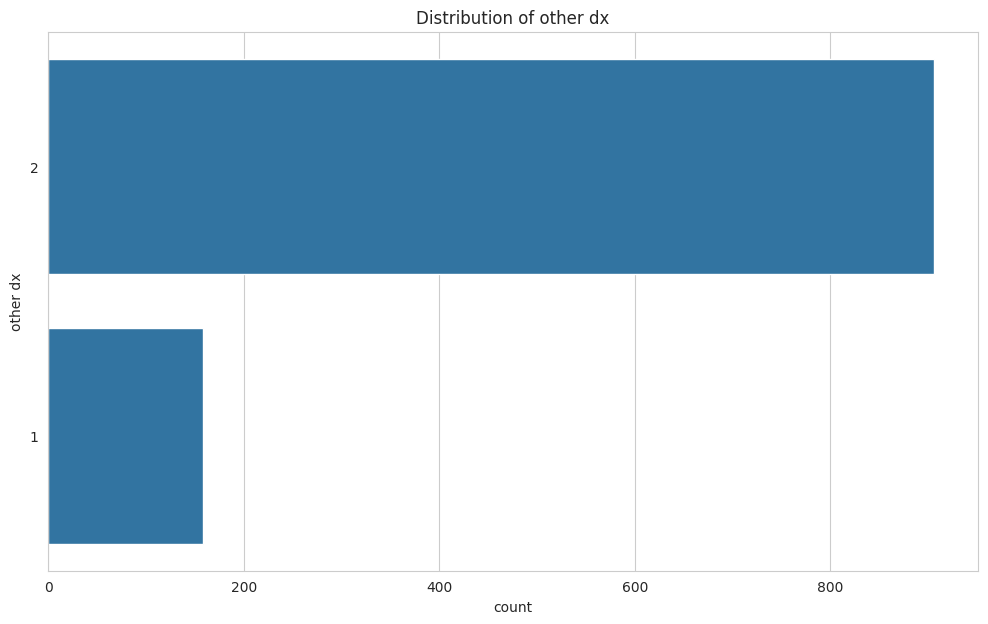

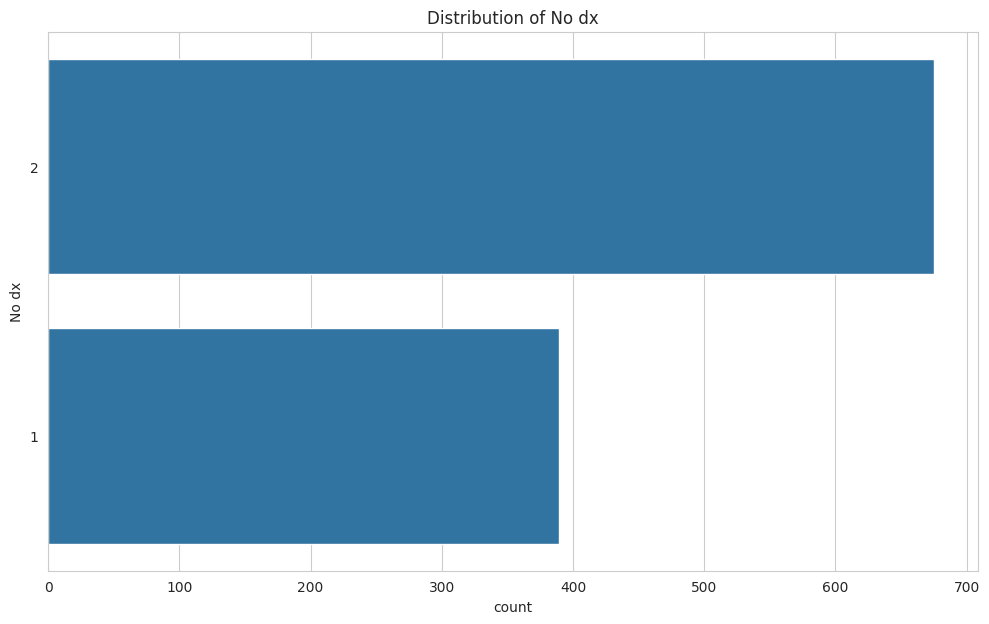

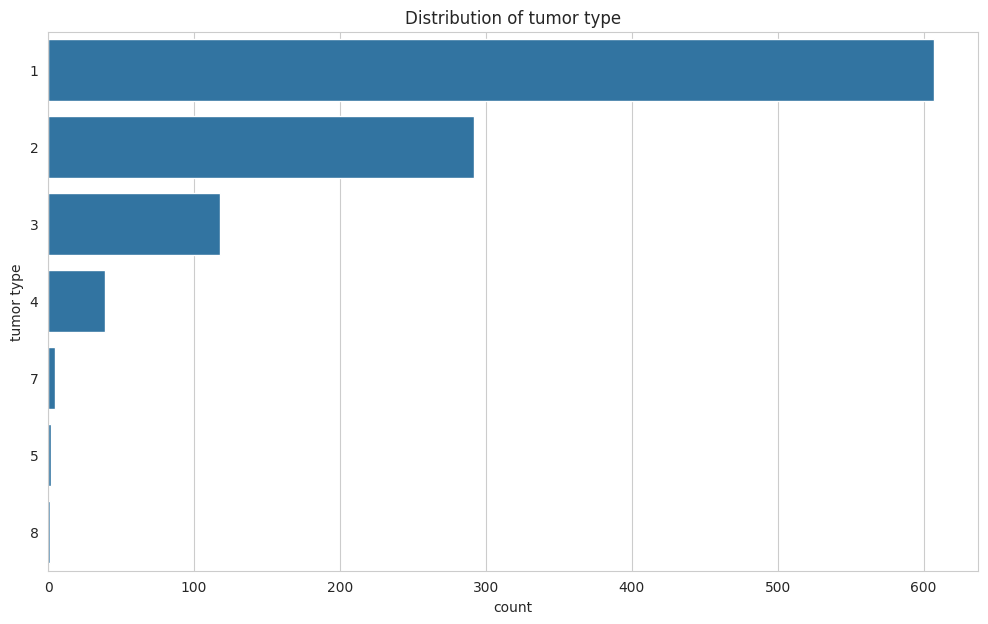

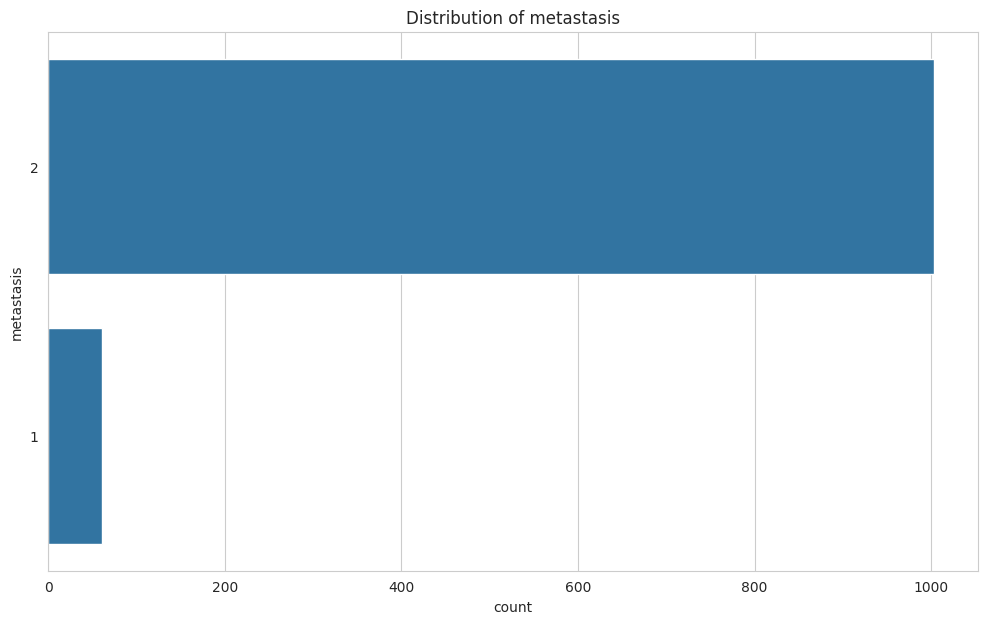

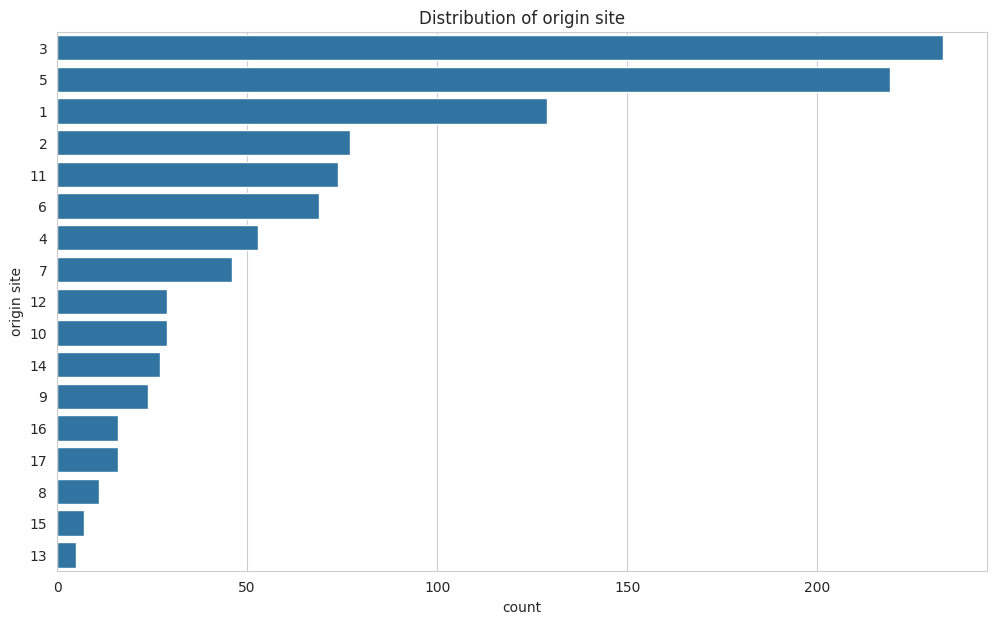

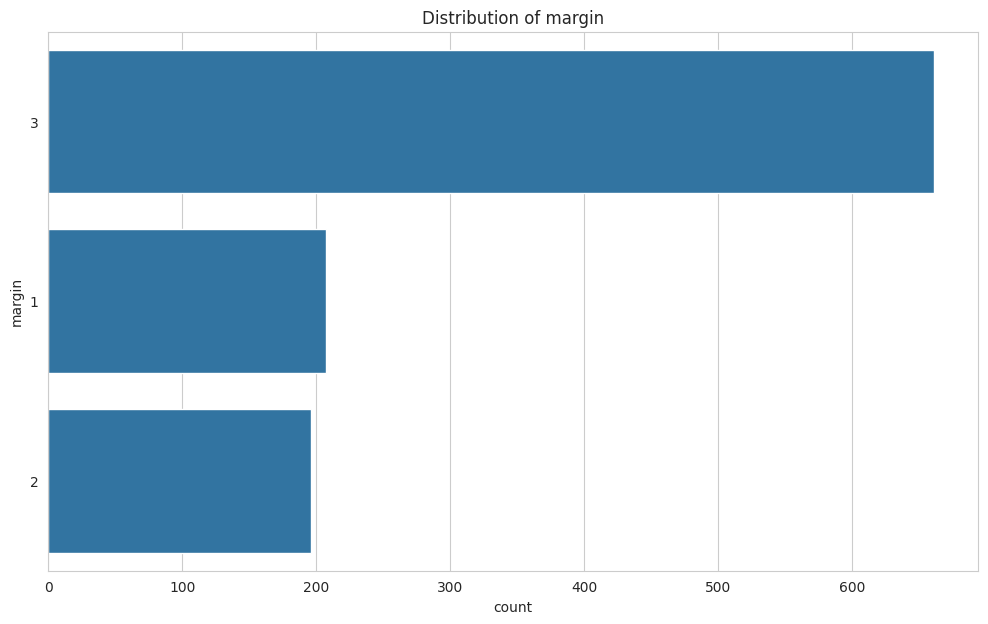

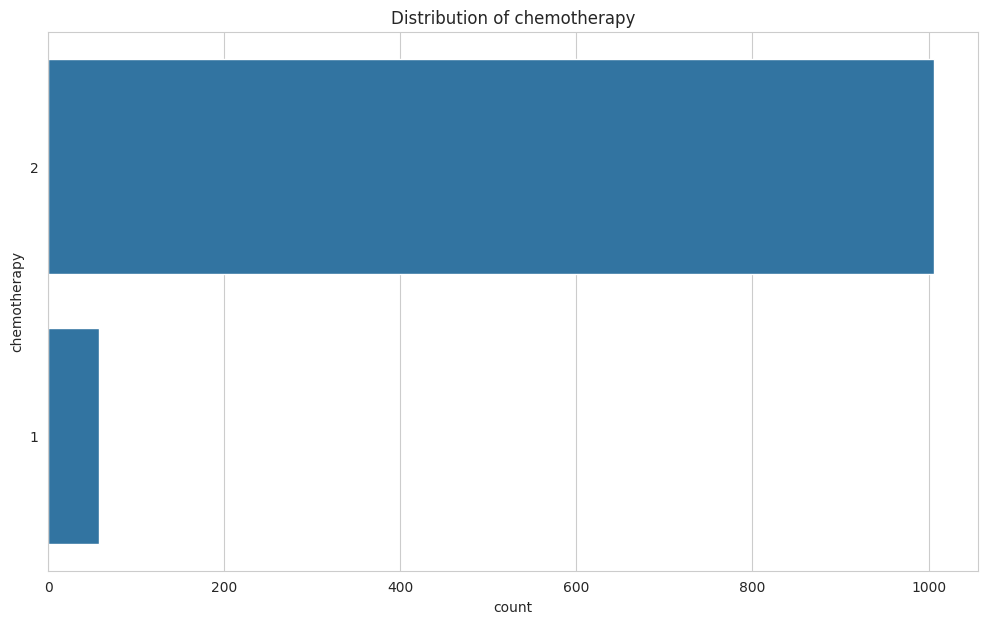

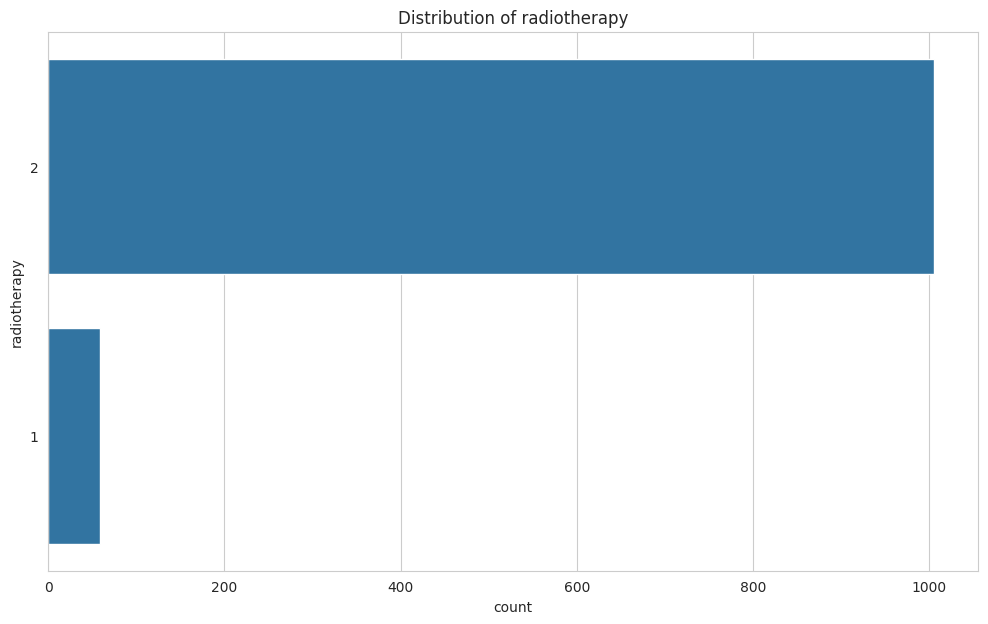

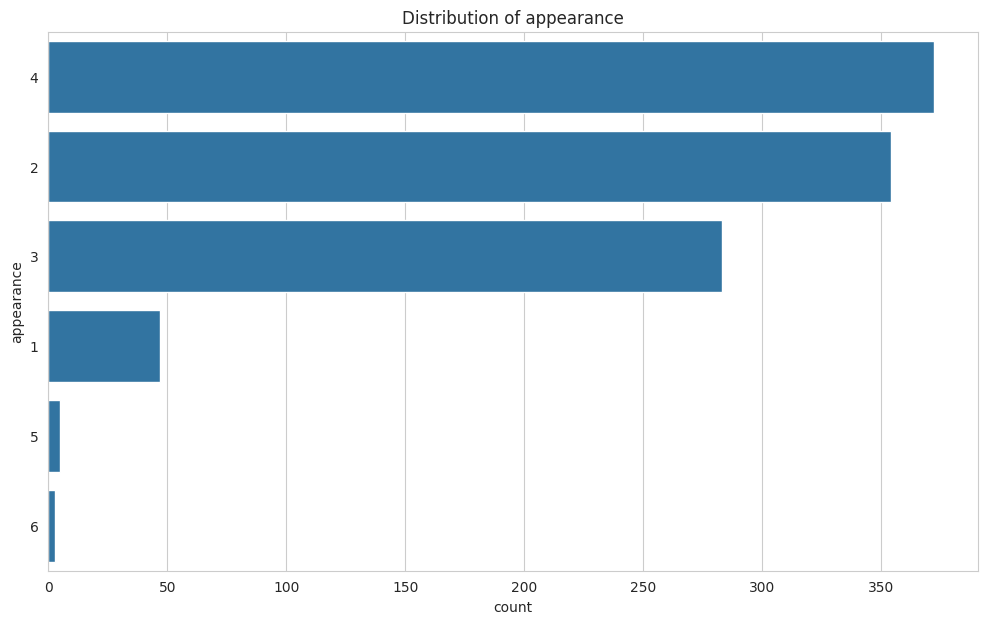

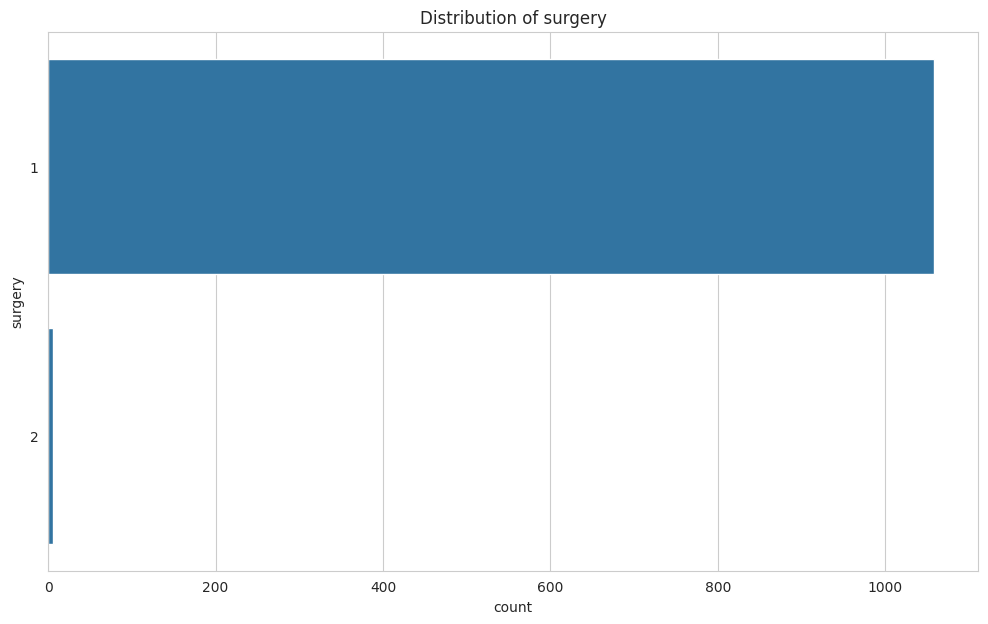

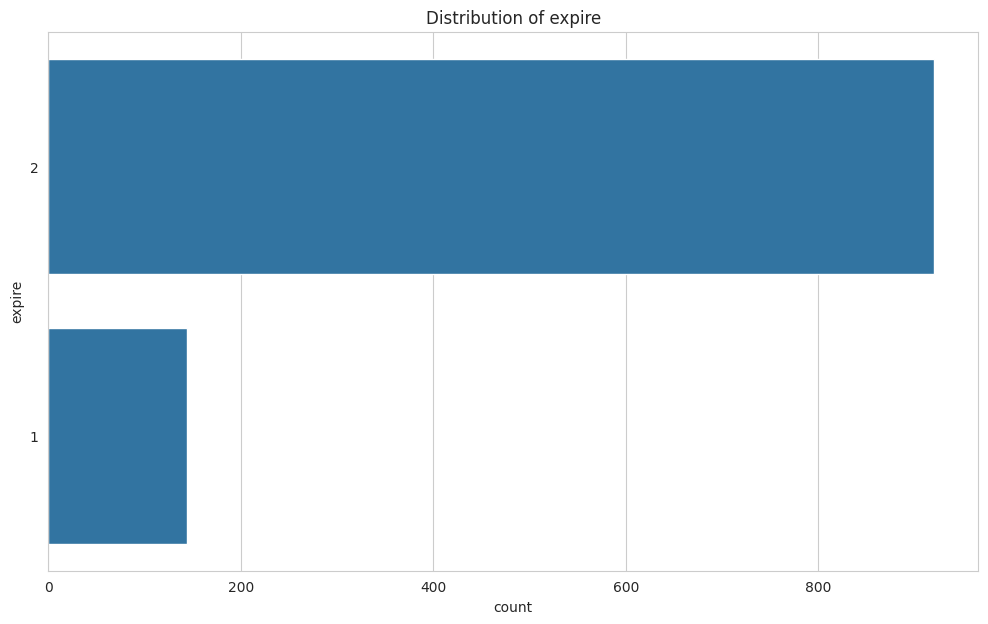

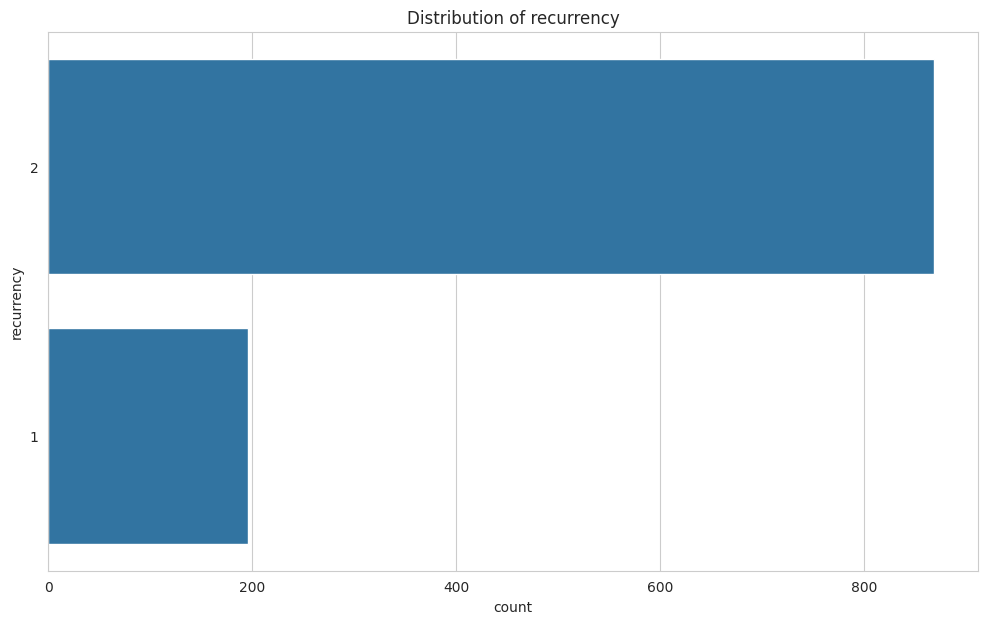

In [ ]:
print("--- Running Univariate Analysis ---")

# Explicitly define numerical columns for plotting using our helper function
age_col = find_col_name(df_clean, ['age'])
size_col = find_col_name(df_clean, ['tumor', 'size'])
depth_col = find_col_name(df_clean, ['tumor', 'depth'])
numerical_cols_to_plot = [col for col in [age_col, size_col, depth_col] if col is not None]
print(f"Numerical columns for EDA: {numerical_cols_to_plot}")

# Treat all other columns as categorical, except for high-cardinality ID-like columns
all_other_cols = [col for col in df_clean.columns if col not in numerical_cols_to_plot]
potential_id_cols = [col for col in all_other_cols if df_clean[col].nunique() > 50 or 'code' in col.lower()]
categorical_cols_to_plot = [col for col in all_other_cols if col not in potential_id_cols]

excluded_cols = potential_id_cols
if excluded_cols:
    print(f"Excluded from EDA (identified as codes/IDs): {excluded_cols}")

# Plot Distributions of Numerical Features
print("\nDistribution of Numerical Features:")
for col in numerical_cols_to_plot:
    plt.figure(figsize=(10, 6))
    sns.histplot(df_clean[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.show()

# Plot Distributions of Categorical Features
print("\nDistribution of Categorical Features:")
for col in categorical_cols_to_plot:
    plt.figure(figsize=(12, 7))
    sns.countplot(y=df_clean[col], order = df_clean[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.show()



--- Running Advanced Association Analysis ---


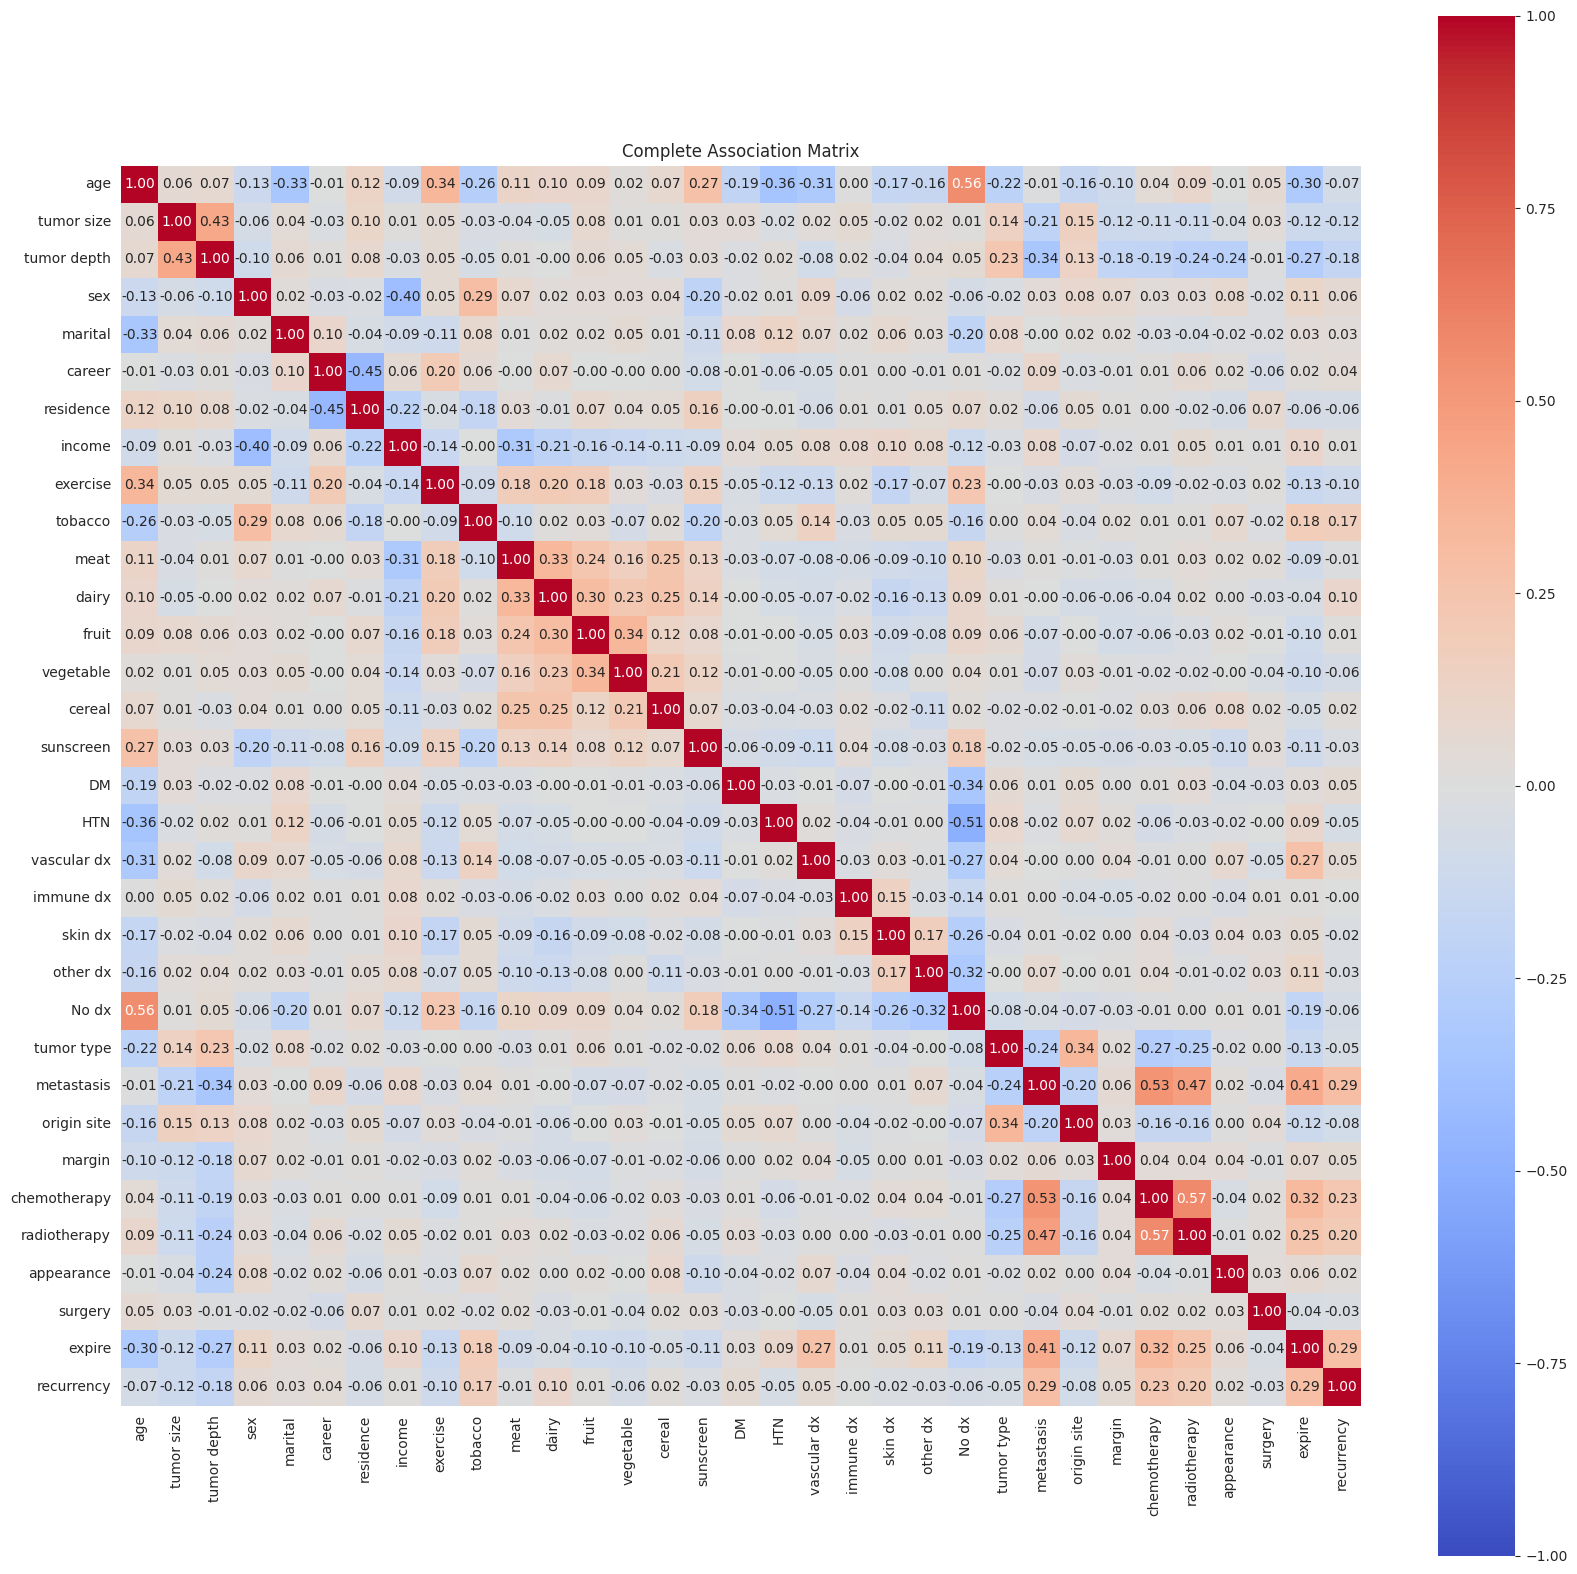

In [22]:
# --- 5.2 Advanced Association Analysis ---
print("\n--- Running Advanced Association Analysis ---")
# Use the columns identified for plotting in the association matrix
analysis_cols = numerical_cols_to_plot + categorical_cols_to_plot
df_for_assoc = df_clean[analysis_cols]

# Compute and plot the associations
assoc_results, _ = associations(df_for_assoc, 
                                figsize=(20, 20), 
                                cmap='coolwarm',
                                title='Complete Association Matrix')


## 6. Feature Engineering


In [23]:
# --- Feature Engineering ---
print("--- Running Feature Engineering ---")
df_engineered = df_clean.copy()

# Find column names robustly
age_col = find_col_name(df_engineered, ['age'])
size_col = find_col_name(df_engineered, ['tumor', 'size'])
depth_col = find_col_name(df_engineered, ['tumor', 'depth'])
margin_col = find_col_name(df_engineered, ['margin'])

# --- 1. Tumor Severity Score ---
if size_col and depth_col:
    df_engineered['tumor_severity_score'] = df_engineered[size_col] + df_engineered[depth_col]
    if margin_col:
        df_engineered['margin_encoded'] = df_engineered[margin_col].apply(lambda x: 1 if str(x).lower() in ['positive', '1'] else 0)
        df_engineered['tumor_severity_score'] += df_engineered['margin_encoded']
    print("Created 'tumor_severity_score'.")

# --- 2. Comorbidity Burden ---
comorbidity_cols = ['dm', 'htn', 'vascular dx', 'immune dx']
existing_comorbidity_cols = [find_col_name(df_engineered, [c]) for c in comorbidity_cols]
existing_comorbidity_cols = [c for c in existing_comorbidity_cols if c is not None]
if existing_comorbidity_cols:
    df_engineered['comorbidity_burden'] = df_engineered[existing_comorbidity_cols].sum(axis=1)
    print(f"Created 'comorbidity_burden' from: {existing_comorbidity_cols}")

# --- 3. Interaction Features ---
if size_col and depth_col and 'tumor_severity_score' in df_engineered.columns and age_col:
    df_engineered['interaction_size_depth'] = df_engineered[size_col] * df_engineered[depth_col]
    df_engineered['interaction_age_severity'] = df_engineered[age_col] * df_engineered['tumor_severity_score']
    print("Created interaction features.")

# --- 4. Treatment Intensity ---
treatment_cols = ['surgery', 'chemotherapy', 'radiotherapy']
existing_treatment_cols = [find_col_name(df_engineered, [c]) for c in treatment_cols]
existing_treatment_cols = [c for c in existing_treatment_cols if c is not None]
if existing_treatment_cols:
    df_engineered['treatment_intensity'] = df_engineered[existing_treatment_cols].sum(axis=1)
    print(f"Created 'treatment_intensity' from: {existing_treatment_cols}")

# --- Display the new features ---
new_feature_cols = ['tumor_severity_score', 'comorbidity_burden', 'interaction_size_depth', 'interaction_age_severity', 'treatment_intensity']
final_new_cols = [col for col in new_feature_cols if col in df_engineered.columns]
if final_new_cols:
    print("\nFirst 5 rows of new features:")
    display(df_engineered[final_new_cols].head())


--- Running Feature Engineering ---
Created 'tumor_severity_score'.
Created 'comorbidity_burden' from: ['DM', 'HTN', 'vascular dx', 'immune dx']
Created interaction features.
Created 'treatment_intensity' from: ['surgery', 'chemotherapy', 'radiotherapy']

First 5 rows of new features:


,tumor_severity_score,comorbidity_burden,interaction_size_depth,interaction_age_severity,treatment_intensity
0,3.2,7,0.6,172.8,5
1,6.3,8,6.5,296.1,5
2,7.5,7,12.5,532.5,5
3,4.3,7,1.2,361.2,5
4,2.2,7,0.4,125.4,5


## 7. Feature Scaling


In [60]:
df_scaled = df_engineered.copy()

# --- Explicitly Define Features to Scale ---
base_numerical_features = [col for col in [age_col, size_col, depth_col] if col is not None and col in df_scaled.columns]
engineered_numerical_features = [
    'tumor_severity_score', 'comorbidity_burden', 
    'interaction_size_depth', 'interaction_age_severity', 'treatment_intensity'
]
existing_engineered_features = [col for col in engineered_numerical_features if col in df_scaled.columns]

features_to_scale = list(dict.fromkeys(base_numerical_features + existing_engineered_features))

print("Scaling the following numerical columns:", features_to_scale)

# Initialize and apply the scaler
if features_to_scale:
    scaler = StandardScaler()
    df_scaled[features_to_scale] = scaler.fit_transform(df_scaled[features_to_scale])
    print("\nFirst 5 rows of scaled features:")
    display(df_scaled[features_to_scale].head())
else:
    print("\nWarning: No numerical features were identified to scale.")


Scaling the following numerical columns: ['age', 'tumor size', 'tumor depth', 'tumor_severity_score', 'comorbidity_burden', 'interaction_size_depth', 'interaction_age_severity', 'treatment_intensity']

First 5 rows of scaled features:


,age,tumor size,tumor depth,tumor_severity_score,comorbidity_burden,interaction_size_depth,interaction_age_severity,treatment_intensity
0,-0.387890,-0.714328,-0.916102,-0.826424,-0.548218,-0.473880,-0.776783,0.252644
1,-0.791665,-0.475485,-0.158359,-0.485109,0.921061,-0.321296,-0.580697,0.252644
2,0.592705,-0.475485,0.668269,-0.352987,-0.548218,-0.166126,-0.204747,0.252644
3,1.342572,-0.594907,-0.847216,-0.705313,-0.548218,-0.458363,-0.477168,0.252644
4,-0.214844,-0.833749,-0.916102,-0.936526,-0.548218,-0.479052,-0.852164,0.252644


## 8. Data  Preparation

In [ ]:
target_col = 'expire'  

# Extract features and target
X = df_scaled.drop(columns=[target_col, 'Code'])
y = df_scaled[target_col]

le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Use balanced split to ensure proportional class distribution
train_idx, test_idx = balanced_split(X, y_encoded, test_size=0.2, random_state=42)
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]



print(f"Classes in y_train: {np.unique(y_train, return_counts=True)}")
print(f"Classes in y_test: {np.unique(y_test, return_counts=True)}")

# Encoder classes reference
print(f"Original classes from encoder: {le.classes_}")

Classes in y_train: (array([0, 1]), array([115, 736]))
Classes in y_test: (array([0, 1]), array([ 29, 184]))
Original classes from encoder: [1 2]


Top Filtered Features: ['tumor depth', 'interaction_size_depth', 'age', 'interaction_age_severity', 'origin site', 'tumor_severity_score', 'tumor size', 'comorbidity_burden', 'tumor type', 'recurrency', 'exercise', 'No dx', 'tobacco', 'metastasis', 'fruit', 'vascular dx', 'vegetable', 'chemotherapy', 'income']


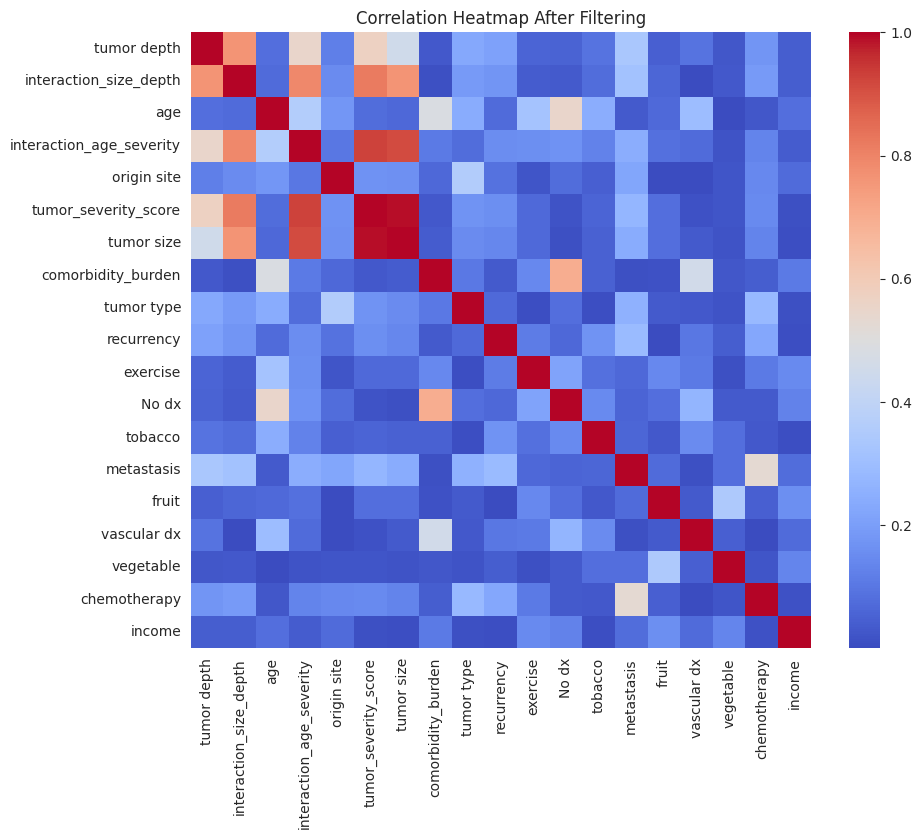

Features After Correlation Removal: ['tumor depth', 'interaction_size_depth', 'age', 'interaction_age_severity', 'origin site', 'comorbidity_burden', 'tumor type', 'recurrency', 'exercise', 'No dx', 'tobacco', 'metastasis', 'fruit', 'vascular dx', 'vegetable', 'chemotherapy', 'income']
Final Selected Features: ['tumor depth', 'interaction_size_depth', 'age', 'interaction_age_severity', 'origin site', 'comorbidity_burden', 'tumor type', 'recurrency', 'exercise', 'No dx', 'tobacco', 'metastasis', 'vascular dx', 'chemotherapy', 'income']


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif, chi2, SelectKBest, RFE
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from collections import Counter

feature_names = X_train.columns.tolist()

# Filter - Select top k features via ensemble of filter
# Handle non-negative for Chi2 (shift if needed)
X_nonneg = X_train.clip(lower=0) 

mi_selector = SelectKBest(mutual_info_classif, k='all')
chi_selector = SelectKBest(chi2, k='all')

# Fit and score
mi_scores = mi_selector.fit(X_train, y_train).scores_
chi_scores = chi_selector.fit(X_nonneg, y_train).scores_

# Ensemble scores: Average 
ensemble_scores = (mi_scores + chi_scores) / 2
top_k = int(len(feature_names) * 0.5)  
top_indices = np.argsort(ensemble_scores)[::-1][:top_k]
X_train_filtered = X_train.iloc[:, top_indices]
X_test_filtered = X_test.iloc[:, top_indices]

print("Top Filtered Features:", X_train_filtered.columns.tolist())

# Remove highly correlated features
# Compute correlation matrix
corr_matrix = X_train_filtered.corr().abs()

# Upper triangle to avoid duplicates
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Drop features with correlation > threshold
threshold = 0.8  # Common value
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

X_train_filtered = X_train_filtered.drop(columns=to_drop)
X_test_filtered = X_test_filtered.drop(columns=to_drop)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap After Filtering')
plt.show()

print("Features After Correlation Removal:", X_train_filtered.columns.tolist())

# Wrapper - RFE with ensemble classifier
# Ensemble base models (diverse for stability)
clf1 = RandomForestClassifier(class_weight='balanced', random_state=42)
clf2 = LogisticRegression(class_weight='balanced', multi_class='multinomial', random_state=42)
ensemble_clf = VotingClassifier(estimators=[('rf', clf1), ('lr', clf2)], voting='soft')

# RFE without SMOTE
rfe = RFE(estimator=clf1, n_features_to_select=15, step=0.1) 

# Cross-validate for robustness
cv = StratifiedKFold(n_splits=3)
selected_indices_in_filtered = []
for train_idx, _ in cv.split(X_train_filtered, y_train):
    rfe.fit(X_train_filtered.iloc[train_idx], y_train[train_idx])
    rfe_support = rfe.support_
    selected_indices_in_filtered.append(np.where(rfe_support)[0])

# Aggregate: Features selected in majority folds
agg_indices = [idx for idx, count in Counter(np.concatenate(selected_indices_in_filtered)).items() if count >= 2]

# Map aggregated indices back to original feature names
selected_features = X_train_filtered.columns[agg_indices].tolist()

# Get indices from original dataframe
final_indices = [feature_names.index(name) for name in selected_features]

X_train_selected = X_train.iloc[:, final_indices]
X_test_selected = X_test.iloc[:, final_indices]

print("Final Selected Features:", selected_features)


## Model 1. Deep Learning Model (TabNet)

Using device: cuda

Class weights: {0: 3.7, 1: 0.578125}

Focal Loss Alpha (positive class weight): 0.5781

Using feature-selected data for TabNet.
Training set shape: (851, 15)
Test set shape: (213, 15)
Number of features: 15
Classes in training set: (array([0, 1]), array([115, 736]))
Classes in test set: (array([0, 1]), array([ 29, 184]))

Focal Loss Configuration:
  - Alpha (positive class weight): 0.5781
  - Gamma: 2.0
  - Loss type: Binary Focal Loss

Training TabNet model with Binary Focal Loss...
epoch 0  | loss: 0.07825 | test_balanced_accuracy: 0.46945 | test_logloss: 0.63611 |  0:00:00s
epoch 1  | loss: 0.06119 | test_balanced_accuracy: 0.491   | test_logloss: 0.4646  |  0:00:01s
epoch 2  | loss: 0.05456 | test_balanced_accuracy: 0.48913 | test_logloss: 0.42873 |  0:00:02s
epoch 3  | loss: 0.05168 | test_balanced_accuracy: 0.49185 | test_logloss: 0.43188 |  0:00:02s
epoch 4  | loss: 0.05219 | test_balanced_accuracy: 0.48913 | test_logloss: 0.4269  |  0:00:03s
epoch 5  | loss:

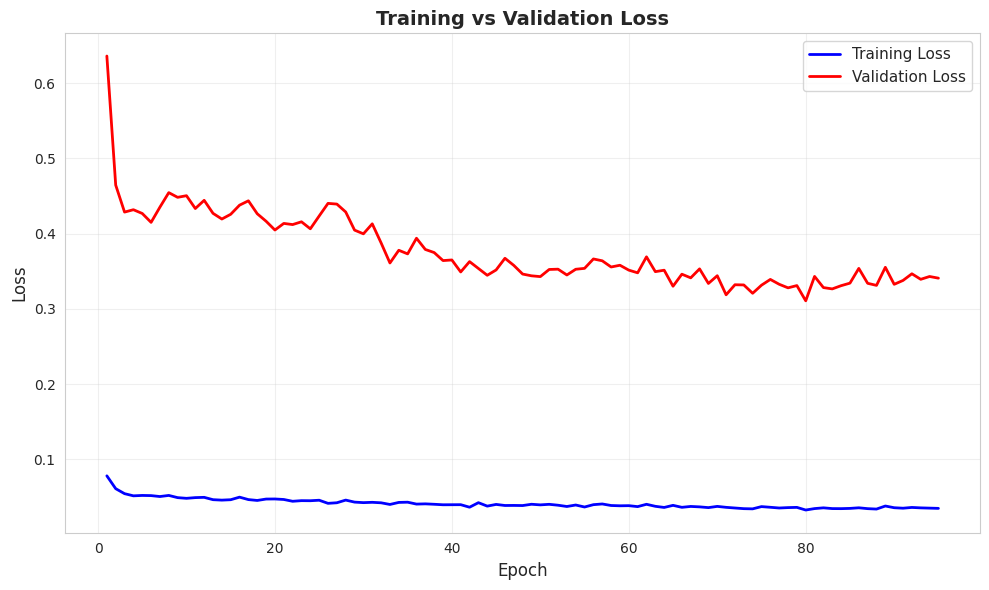


TabNet Predictions (Binary Classification)

TabNet Results (Binary Classification - Using Selected Features):
------------------------------------------------------------

Accuracy: 0.9061
F1 Score (macro): 0.7734
F1 Score (weighted): 0.8996
F1 Score (binary, pos_label=1): 0.9468
ROC AUC Score: 0.9427

Classification Report:
              precision    recall  f1-score   support

     Class 0     0.7143    0.5172    0.6000        29
     Class 1     0.9271    0.9674    0.9468       184

    accuracy                         0.9061       213
   macro avg     0.8207    0.7423    0.7734       213
weighted avg     0.8981    0.9061    0.8996       213


Confusion Matrix:
[[ 15  14]
 [  6 178]]


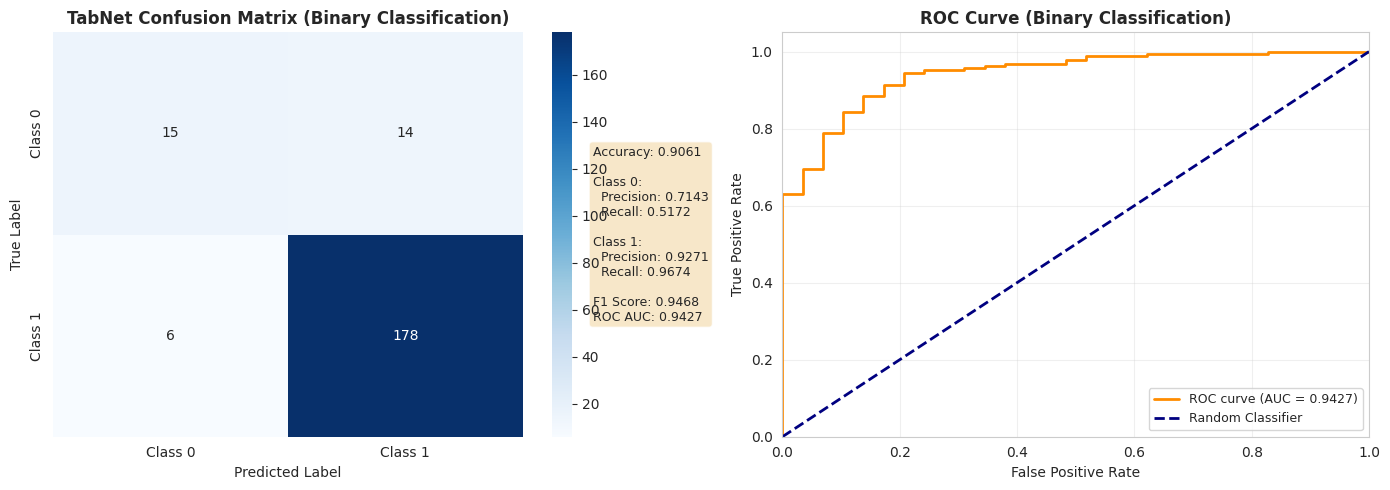

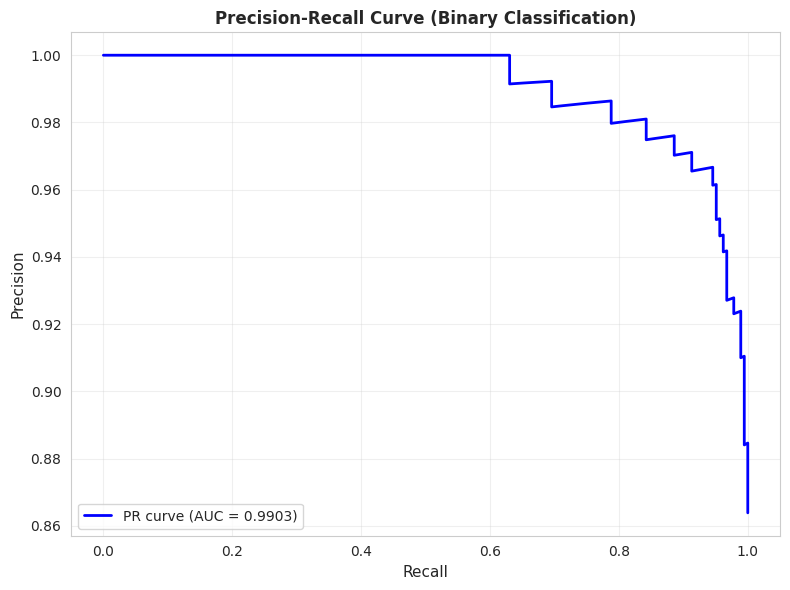


Top 15 Most Important Features:
                     feature  importance
2                        age    0.239129
11                metastasis    0.117260
6                 tumor type    0.102743
12               vascular dx    0.097146
7                 recurrency    0.069638
14                    income    0.061888
3   interaction_age_severity    0.061831
4                origin site    0.059703
10                   tobacco    0.046299
13              chemotherapy    0.040364
0                tumor depth    0.027105
5         comorbidity_burden    0.025684
8                   exercise    0.025590
9                      No dx    0.016755
1     interaction_size_depth    0.008864


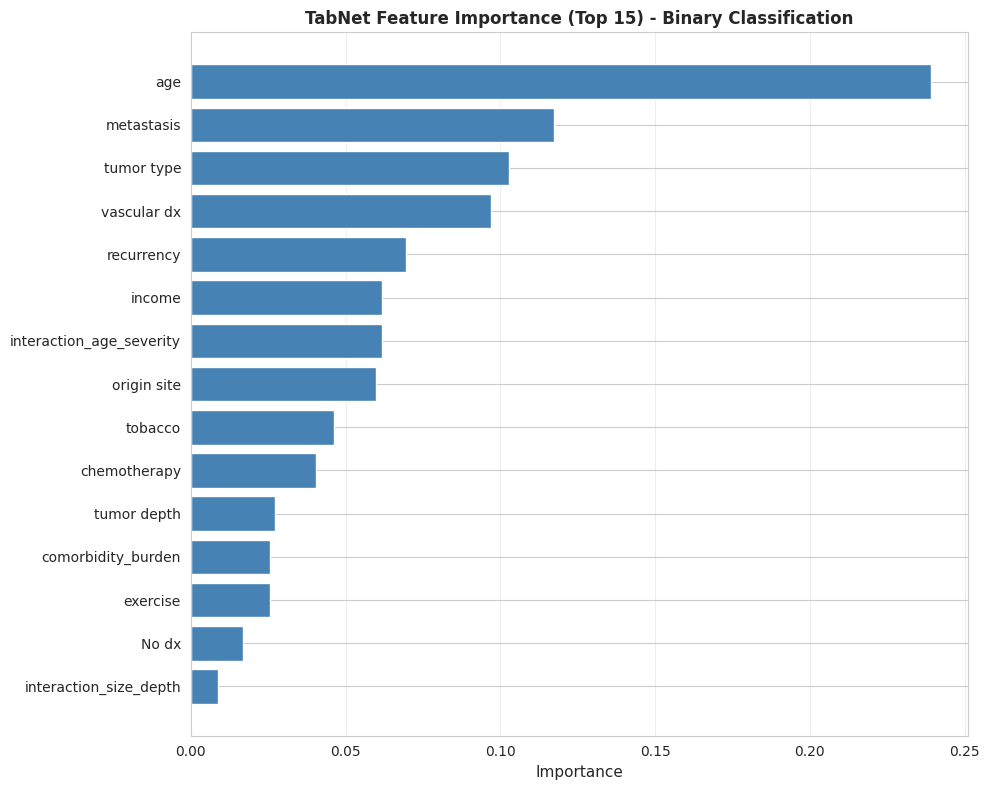


Class Distribution Summary
Training set - Class 0: 115, Class 1: 736
Test set - Class 0: 29, Class 1: 184
Predicted - Class 0: 21, Class 1: 192


In [ ]:
## TabNet Deep Learning Model with Focal Loss


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

try:
    from pytorch_tabnet.tab_model import TabNetClassifier
except ImportError:
    print("Installing pytorch-tabnet...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "pytorch-tabnet"])
    from pytorch_tabnet.tab_model import TabNetClassifier

from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, f1_score, 
                            roc_auc_score, roc_curve, precision_recall_curve, auc,
                            precision_score, recall_score)
import warnings
warnings.filterwarnings('ignore')

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Binary Focal Loss implementation
class BinaryFocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):

        super(BinaryFocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        
    def forward(self, inputs, targets):
        targets = targets.float()
        
        # Binary cross entropy
        bce_loss = nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        
        # Calculate p_t
        p_t = torch.exp(-bce_loss)
        
        # Focal loss
        focal_loss = ((1 - p_t) ** self.gamma) * bce_loss
        
        # Apply alpha weighting
        if self.alpha is not None:
            alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
            focal_loss = alpha_t * focal_loss
            
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# Calculate class weights for imbalanced binary data
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))
print(f"\nClass weights: {class_weight_dict}")


alpha_value = class_weight_dict[1] if 1 in class_weight_dict else 0.5
print(f"\nFocal Loss Alpha (positive class weight): {alpha_value:.4f}")

# Prepare data for TabNet
if 'X_train_selected' in globals() and 'selected_features' in globals():
    print("\nUsing feature-selected data for TabNet.")
    tabnet_feature_names = selected_features
else:
    print("\nWarning: Selected features not found. Using original features.")
    X_train_selected = X_train_tabnet
    X_test_selected = X_test_tabnet
    tabnet_feature_names = X_train.columns.tolist() if 'X_train' in globals() else []

print(f"Training set shape: {X_train_selected.shape}")
print(f"Test set shape: {X_test_selected.shape}")
print(f"Number of features: {len(tabnet_feature_names)}")
print(f"Classes in training set: {np.unique(y_train, return_counts=True)}")
print(f"Classes in test set: {np.unique(y_test, return_counts=True)}")

tabnet_params = {
    'n_d': 8,  # Dimension of the decision layer
    'n_a': 8,  # Dimension of the attention layer
    'n_steps': 4,  # Number of steps in the encoder
    'gamma': 1.3,  # Coefficient for feature reusage
    'n_independent': 2,  # Number of independent Gated Linear Units per step
    'n_shared': 2,  # Number of shared Gated Linear Units per step
    'lambda_sparse': 0.005,  # Sparsity regularization
    'optimizer_fn': optim.Adam,
    'optimizer_params': dict(lr=0.01, weight_decay=1e-5),
    'mask_type': 'entmax',  # 'sparsemax' or 'entmax'
    'n_shared_decoder': 1,
    'n_indep_decoder': 1,
    'clip_value': None,
    'verbose': 1,
    'seed': 42,
    'device_name': 'cuda' if torch.cuda.is_available() else 'cpu'
}

# Custom Binary Focal Loss wrapper for TabNet
class TabNetBinaryFocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0):
        super(TabNetBinaryFocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        
    def forward(self, inputs, targets):
        """
        TabNet outputs logits for binary classification.
        For binary case, inputs shape is [batch_size, 2] (logits for both classes)
        We need to extract the positive class logit for binary focal loss.
        """
        # TabNet outputs logits for both classes [batch_size, 2]
        # Extract the logit for class 1 (positive class)
        if inputs.dim() > 1 and inputs.size(1) == 2:
            # Binary classification: use logit for class 1
            logits = inputs[:, 1]  # Positive class logit
        else:
            logits = inputs.squeeze()
        
        # Convert targets to float
        targets = targets.float()
        
        # Binary cross entropy
        bce_loss = nn.functional.binary_cross_entropy_with_logits(logits, targets, reduction='none')
        
        # Calculate p_t
        p_t = torch.exp(-bce_loss)
        
        # Focal loss
        focal_loss = ((1 - p_t) ** self.gamma) * bce_loss
        
        # Apply alpha weighting
        if self.alpha is not None:
            alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
            focal_loss = alpha_t * focal_loss
            
        return focal_loss.mean()

# Create focal loss with alpha weighting
focal_loss_fn = TabNetBinaryFocalLoss(alpha=alpha_value, gamma=2.0)

print(f"\nFocal Loss Configuration:")
print(f"  - Alpha (positive class weight): {alpha_value:.4f}")
print(f"  - Gamma: 2.0")
print(f"  - Loss type: Binary Focal Loss")

# Initialize TabNet with focal loss
# Note: TabNetClassifier supports binary classification natively
clf_tabnet = TabNetClassifier(**tabnet_params)

# Train TabNet with Focal Loss
print("\nTraining TabNet model with Binary Focal Loss...")

clf_tabnet.fit(
    X_train_selected.values if isinstance(X_train_selected, pd.DataFrame) else X_train_selected, 
    y_train,
    eval_set=[(X_test_selected.values if isinstance(X_test_selected, pd.DataFrame) else X_test_selected, y_test)],
    eval_name=['test'],
    eval_metric=['balanced_accuracy', 'logloss'],
    max_epochs=200,
    patience=15,
    batch_size=64,
    virtual_batch_size=16,
    loss_fn=focal_loss_fn,
    weights=0,
    compute_importance=True
)

# Extract training history for plotting
history_obj = clf_tabnet.history

# Plot Training vs Validation Loss
if history_obj is not None:
    if hasattr(history_obj, 'history'):
        history = history_obj.history
    elif isinstance(history_obj, dict):
        history = history_obj
    else:
        history = {}
    
    train_loss = history.get('loss', [])
    val_loss = history.get('test_logloss', [])  # Validation loss (logloss)
    
    # Determine number of epochs
    if train_loss and val_loss and len(train_loss) == len(val_loss):
        epochs = range(1, len(train_loss) + 1)
        
        # Plot Training vs Validation Loss
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, train_loss, 'b-', label='Training Loss', linewidth=2)
        plt.plot(epochs, val_loss, 'r-', label='Validation Loss', linewidth=2)
        plt.title('Training vs Validation Loss', fontsize=14, fontweight='bold')
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel('Loss', fontsize=12)
        plt.legend(fontsize=11)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

# Make predictions
print("\n" + "="*60)
print("TabNet Predictions (Binary Classification)")
print("="*60)

y_pred_tabnet = clf_tabnet.predict(X_test_selected.values if isinstance(X_test_selected, pd.DataFrame) else X_test_selected)
y_pred_proba_tabnet = clf_tabnet.predict_proba(X_test_selected.values if isinstance(X_test_selected, pd.DataFrame) else X_test_selected)

# For binary classification, get probabilities for positive class (class 1)
y_pred_proba_positive = y_pred_proba_tabnet[:, 1] if y_pred_proba_tabnet.shape[1] > 1 else y_pred_proba_tabnet[:, 0]

# Evaluate the model
print("\nTabNet Results (Binary Classification - Using Selected Features):")
print("-" * 60)

accuracy = accuracy_score(y_test, y_pred_tabnet)
f1_macro = f1_score(y_test, y_pred_tabnet, average='macro')
f1_weighted = f1_score(y_test, y_pred_tabnet, average='weighted')
f1_binary = f1_score(y_test, y_pred_tabnet, pos_label=1)
precision_class_0 = precision_score(y_test, y_pred_tabnet, pos_label=0, zero_division=0)
precision_class_1 = precision_score(y_test, y_pred_tabnet, pos_label=1, zero_division=0)
recall_class_0 = recall_score(y_test, y_pred_tabnet, pos_label=0, zero_division=0)
recall_class_1 = recall_score(y_test, y_pred_tabnet, pos_label=1, zero_division=0)

print(f"\nAccuracy: {accuracy:.4f}")
print(f"F1 Score (macro): {f1_macro:.4f}")
print(f"F1 Score (weighted): {f1_weighted:.4f}")
print(f"F1 Score (binary, pos_label=1): {f1_binary:.4f}")

# Calculate ROC AUC for binary classification
roc_auc = roc_auc_score(y_test, y_pred_proba_positive)
print(f"ROC AUC Score: {roc_auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_tabnet,
                          target_names=['Class 0', 'Class 1'],
                          digits=4))

print("\nConfusion Matrix:")
cm_tabnet = confusion_matrix(y_test, y_pred_tabnet)
print(cm_tabnet)

# Visualize confusion matrix for binary classification
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix Heatmap
sns.heatmap(cm_tabnet, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'],
            ax=axes[0])
axes[0].set_title('TabNet Confusion Matrix (Binary Classification)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=10)
axes[0].set_xlabel('Predicted Label', fontsize=10)

# Calculate metrics from confusion matrix
tn, fp, fn, tp = cm_tabnet.ravel()
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

# Add text annotations with per-class metrics
metrics_text = f'Accuracy: {accuracy:.4f}\n'
metrics_text += f'\nClass 0:\n'
metrics_text += f'  Precision: {precision_class_0:.4f}\n'
metrics_text += f'  Recall: {recall_class_0:.4f}\n'
metrics_text += f'\nClass 1:\n'
metrics_text += f'  Precision: {precision_class_1:.4f}\n'
metrics_text += f'  Recall: {recall_class_1:.4f}\n'
metrics_text += f'\nF1 Score: {f1_binary:.4f}\n'
metrics_text += f'ROC AUC: {roc_auc:.4f}'

axes[0].text(1.15, 0.5, metrics_text, transform=axes[0].transAxes,
            fontsize=9, verticalalignment='center',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_positive)
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate', fontsize=10)
axes[1].set_ylabel('True Positive Rate', fontsize=10)
axes[1].set_title('ROC Curve (Binary Classification)', fontsize=12, fontweight='bold')
axes[1].legend(loc="lower right", fontsize=9)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Precision-Recall Curve
plt.figure(figsize=(8, 6))
precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_test, y_pred_proba_positive)
pr_auc = auc(recall_curve, precision_curve)
plt.plot(recall_curve, precision_curve, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall', fontsize=11)
plt.ylabel('Precision', fontsize=11)
plt.title('Precision-Recall Curve (Binary Classification)', fontsize=12, fontweight='bold')
plt.legend(loc="lower left", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Feature importance from TabNet
feature_importance = clf_tabnet.feature_importances_

# Create feature importance dataframe using the correct feature names
importance_df = pd.DataFrame({
    'feature': tabnet_feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("\nTop 15 Most Important Features:")
print(importance_df.head(15))

# Visualize feature importance
plt.figure(figsize=(10, 8))
top_features = importance_df.head(15)
plt.barh(range(len(top_features)), top_features['importance'].values, color='steelblue')
plt.yticks(range(len(top_features)), top_features['feature'].values)
plt.xlabel('Importance', fontsize=11)
plt.title('TabNet Feature Importance (Top 15) - Binary Classification', fontsize=12, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# Class distribution summary
print("\n" + "="*60)
print("Class Distribution Summary")
print("="*60)
print(f"Training set - Class 0: {(y_train == 0).sum()}, Class 1: {(y_train == 1).sum()}")
print(f"Test set - Class 0: {(y_test == 0).sum()}, Class 1: {(y_test == 1).sum()}")
print(f"Predicted - Class 0: {(y_pred_tabnet == 0).sum()}, Class 1: {(y_pred_tabnet == 1).sum()}")

## Handling Class Imbalance (SMOTE-ENN) For ML Models

In [ ]:
# --- Apply SMOTE-ENN to the training data ---
smote_enn = SMOTEENN(random_state=42)

print("Class distribution before resampling:")
print(Counter(y_train))

# Apply the resampling
print("\nApplying SMOTE-ENN...")
X_resampled, y_resampled = smote_enn.fit_resample(X_train_selected, y_train)

print("\nClass distribution after resampling:")
print(Counter(y_resampled))

print(f"\nOriginal training set shape: {X_train_selected.shape}")
print(f"Resampled training set shape: {X_resampled.shape}")


Running t-SNE for visualization... This may take a few moments.


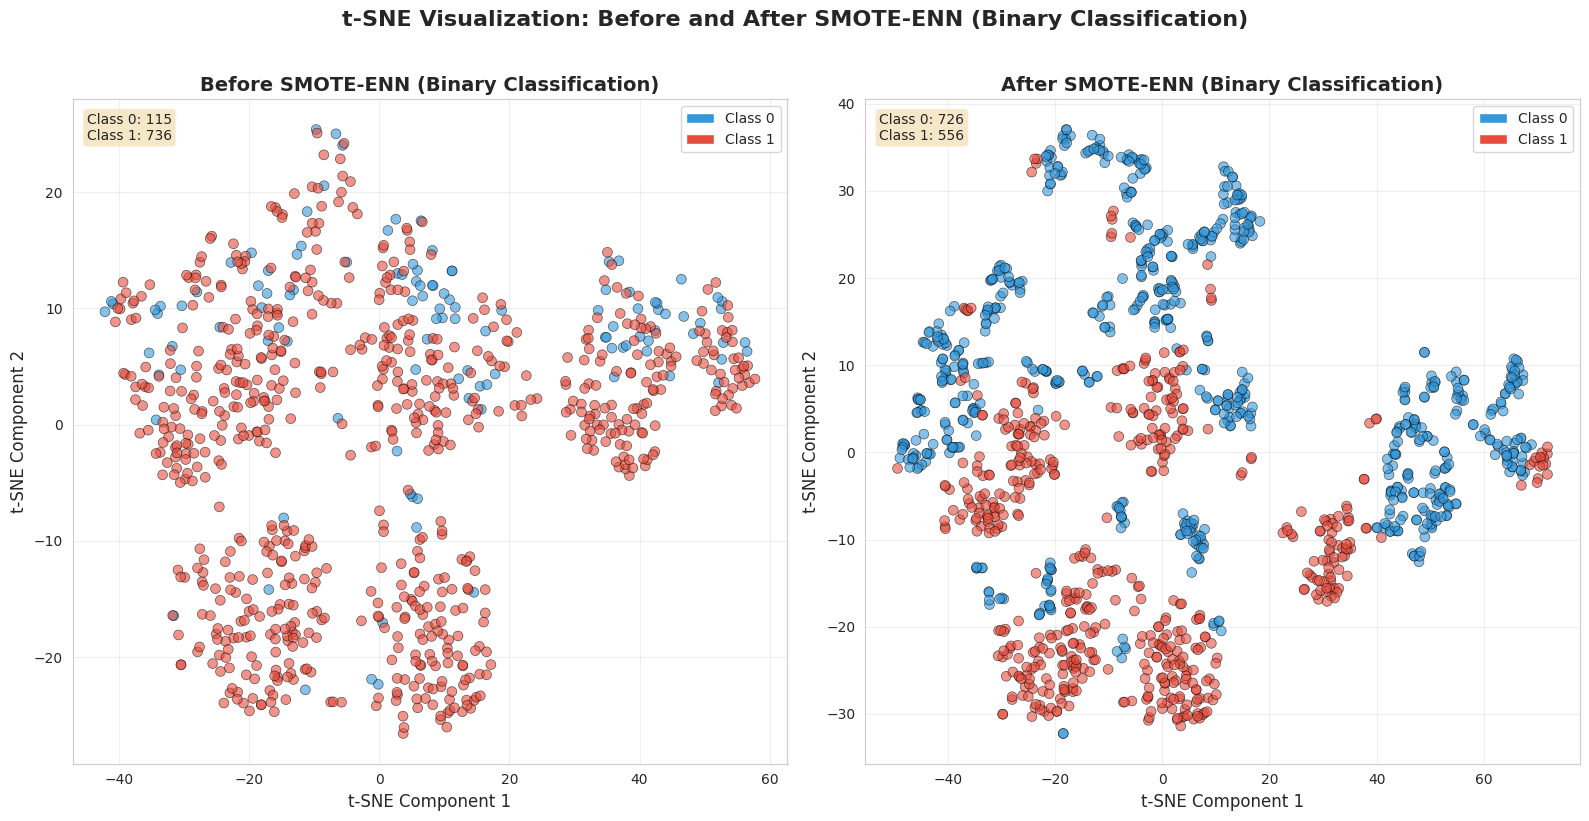


Class Distribution Summary
Before SMOTE-ENN:
  Class 0: 115 (13.51%)
  Class 1: 736 (86.49%)
  Total: 851

After SMOTE-ENN:
  Class 0: 726 (56.63%)
  Class 1: 556 (43.37%)
  Total: 1282


In [ ]:
from sklearn.manifold import TSNE

# --- t-SNE Visualization for Binary Classification ---
print("Running t-SNE for visualization... This may take a few moments.")

# Set up t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(X_train_selected)-1))

# Fit and transform the original training data
X_train_tsne = tsne.fit_transform(X_train_selected)

# Fit and transform the resampled training data
X_resampled_tsne = tsne.fit_transform(X_resampled)

# Plot the results
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Define colors for binary classification (Class 0: blue, Class 1: red)
binary_palette = {0: '#3498db', 1: '#e74c3c'}  

# Before SMOTE-ENN
scatter1 = axes[0].scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], 
                          c=[binary_palette[label] for label in y_train], 
                          alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
axes[0].set_title('Before SMOTE-ENN (Binary Classification)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('t-SNE Component 1', fontsize=12)
axes[0].set_ylabel('t-SNE Component 2', fontsize=12)
axes[0].grid(True, alpha=0.3)

# Add legend for binary classes
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=binary_palette[0], label='Class 0'),
                   Patch(facecolor=binary_palette[1], label='Class 1')]
axes[0].legend(handles=legend_elements, loc='best', fontsize=10)

# Add class distribution info
class_0_count = (y_train == 0).sum()
class_1_count = (y_train == 1).sum()
axes[0].text(0.02, 0.98, f'Class 0: {class_0_count}\nClass 1: {class_1_count}',
            transform=axes[0].transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

# After SMOTE-ENN
scatter2 = axes[1].scatter(X_resampled_tsne[:, 0], X_resampled_tsne[:, 1], 
                          c=[binary_palette[label] for label in y_resampled], 
                          alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
axes[1].set_title('After SMOTE-ENN (Binary Classification)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('t-SNE Component 1', fontsize=12)
axes[1].set_ylabel('t-SNE Component 2', fontsize=12)
axes[1].grid(True, alpha=0.3)

# Add legend for binary classes
axes[1].legend(handles=legend_elements, loc='best', fontsize=10)

# Add class distribution info after resampling
class_0_resampled = (y_resampled == 0).sum()
class_1_resampled = (y_resampled == 1).sum()
axes[1].text(0.02, 0.98, f'Class 0: {class_0_resampled}\nClass 1: {class_1_resampled}',
            transform=axes[1].transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

plt.suptitle('t-SNE Visualization: Before and After SMOTE-ENN (Binary Classification)', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print class distribution summary
print("\n" + "="*60)
print("Class Distribution Summary")
print("="*60)
print(f"Before SMOTE-ENN:")
print(f"  Class 0: {class_0_count} ({class_0_count/len(y_train)*100:.2f}%)")
print(f"  Class 1: {class_1_count} ({class_1_count/len(y_train)*100:.2f}%)")
print(f"  Total: {len(y_train)}")
print(f"\nAfter SMOTE-ENN:")
print(f"  Class 0: {class_0_resampled} ({class_0_resampled/len(y_resampled)*100:.2f}%)")
print(f"  Class 1: {class_1_resampled} ({class_1_resampled/len(y_resampled)*100:.2f}%)")
print(f"  Total: {len(y_resampled)}")
print("="*60)

## Model 2. Ensemble Modeling (XGBoost + CatBoost + LightGBM)

In [30]:
# Model and evaluation imports
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter

# --- 1. Define and Configure Models for Binary Classification ---

# For XGBoost binary classification, calculate scale_pos_weight
# This is the ratio of negative class (0) to positive class (1)
counter = Counter(y_train)
if 0 in counter and 1 in counter:
    scale_pos_weight = counter[0] / counter[1]  # negative/positive ratio
    print(f"XGBoost scale_pos_weight (Class 0/Class 1): {scale_pos_weight:.3f}")
    print(f"Class distribution - Class 0: {counter[0]}, Class 1: {counter[1]}")
else:
    scale_pos_weight = 1.0
    print("Warning: Both classes not found, using scale_pos_weight=1.0")

# For CatBoost, compute class weights from resampled data
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_resampled), y=y_resampled)
cat_weights = dict(zip(np.unique(y_resampled), class_weights))
print(f"CatBoost class weights: {cat_weights}")

# Define the individual models with parameters for handling binary classification imbalance
xgb_clf = xgb.XGBClassifier(objective='binary:logistic',  # Binary classification objective
                            eval_metric='logloss',  # Binary log loss
                            use_label_encoder=False,
                            scale_pos_weight=scale_pos_weight,
                            random_state=42,
                            n_estimators=100)

lgbm_clf = lgb.LGBMClassifier(objective='binary',  # Explicitly set binary objective
                              class_weight='balanced',
                              random_state=42,
                              n_estimators=100,
                              verbose=-1)

cat_clf = cb.CatBoostClassifier(class_weights=cat_weights,
                                random_state=42,
                                verbose=0,
                                iterations=100,
                                loss_function='Logloss')  # Binary classification loss

XGBoost scale_pos_weight (Class 0/Class 1): 0.156
Class distribution - Class 0: 115, Class 1: 736
CatBoost class weights: {0: 0.8829201101928374, 1: 1.1528776978417266}


In [31]:
# --- 2. Create Soft-Voting Ensemble ---
ensemble_clf = VotingClassifier(
    estimators=[('xgb', xgb_clf), ('lgbm', lgbm_clf), ('cat', cat_clf)],
    voting='soft'
)


In [32]:
# --- 3. Train Individual Models and Ensemble ---
print("Training individual boosting models...")

# Train each model individually
print("Training XGBoost...")
xgb_clf.fit(X_resampled, y_resampled)
print("XGBoost training complete.")

print("Training LightGBM...")
lgbm_clf.fit(X_resampled, y_resampled)
print("LightGBM training complete.")

print("Training CatBoost...")
cat_clf.fit(X_resampled, y_resampled)
print("CatBoost training complete.")

# Train the ensemble
print("\nTraining the soft-voting ensemble model...")
ensemble_clf.fit(X_resampled, y_resampled)
print("Ensemble training complete.")

Training individual boosting models...
Training XGBoost...
XGBoost training complete.
Training LightGBM...
LightGBM training complete.
Training CatBoost...
CatBoost training complete.

Training the soft-voting ensemble model...
Ensemble training complete.


EVALUATING INDIVIDUAL BOOSTING MODELS (BINARY CLASSIFICATION)

XGBoost Evaluation (Binary Classification)

Classification Report:
              precision    recall  f1-score   support

     Class 0     0.4407    0.8966    0.5909        29
     Class 1     0.9805    0.8207    0.8935       184

    accuracy                         0.8310       213
   macro avg     0.7106    0.8586    0.7422       213
weighted avg     0.9070    0.8310    0.8523       213


Detailed Metrics:
  Accuracy: 0.8310
  F1 Score (macro): 0.7422
  F1 Score (weighted): 0.8523
  F1 Score (binary, pos_label=1): 0.8935
  Precision (Class 1): 0.9805
  Recall/Sensitivity (Class 1): 0.8207
  ROC AUC Score: 0.9084

Confusion Matrix Metrics:
  True Negatives (TN): 26
  False Positives (FP): 3
  False Negatives (FN): 33
  True Positives (TP): 151
  Sensitivity (Recall): 0.8207
  Specificity: 0.8966


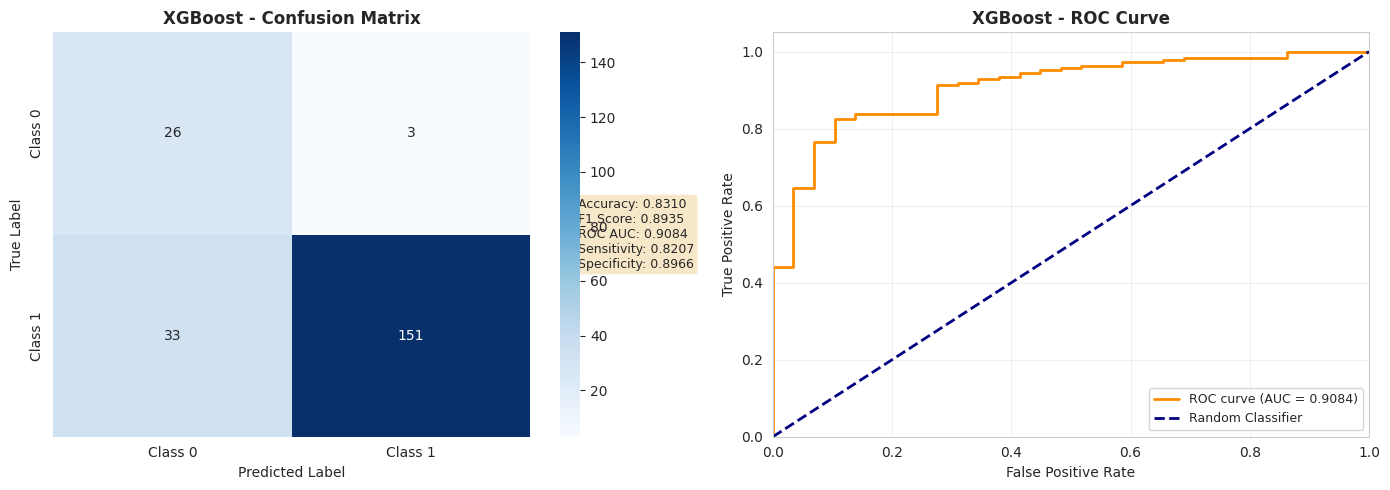

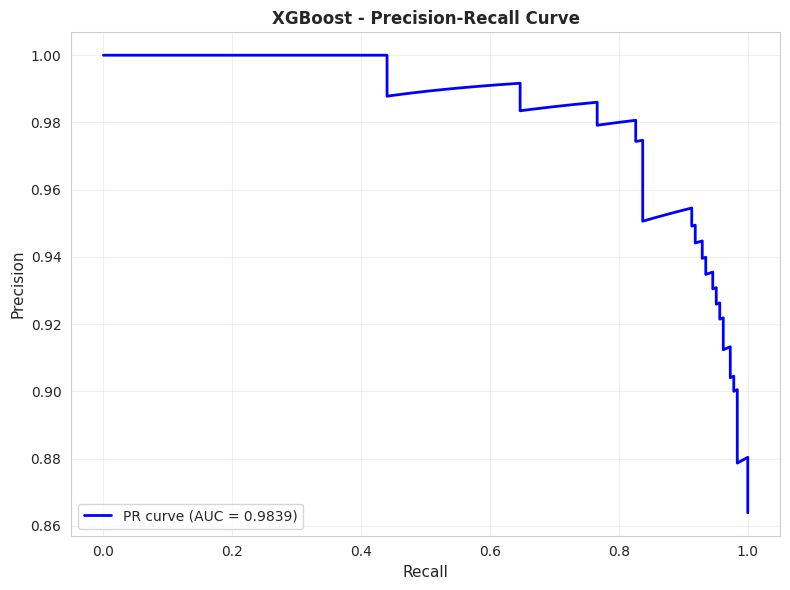


LightGBM Evaluation (Binary Classification)

Classification Report:
              precision    recall  f1-score   support

     Class 0     0.4490    0.7586    0.5641        29
     Class 1     0.9573    0.8533    0.9023       184

    accuracy                         0.8404       213
   macro avg     0.7031    0.8059    0.7332       213
weighted avg     0.8881    0.8404    0.8563       213


Detailed Metrics:
  Accuracy: 0.8404
  F1 Score (macro): 0.7332
  F1 Score (weighted): 0.8563
  F1 Score (binary, pos_label=1): 0.9023
  Precision (Class 1): 0.9573
  Recall/Sensitivity (Class 1): 0.8533
  ROC AUC Score: 0.9202

Confusion Matrix Metrics:
  True Negatives (TN): 22
  False Positives (FP): 7
  False Negatives (FN): 27
  True Positives (TP): 157
  Sensitivity (Recall): 0.8533
  Specificity: 0.7586


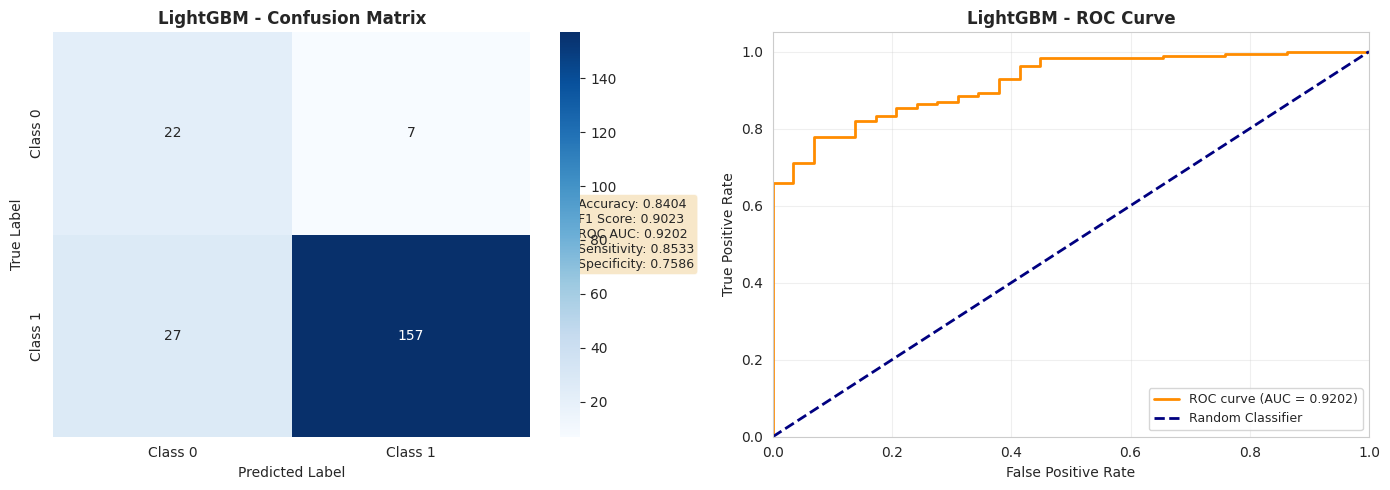

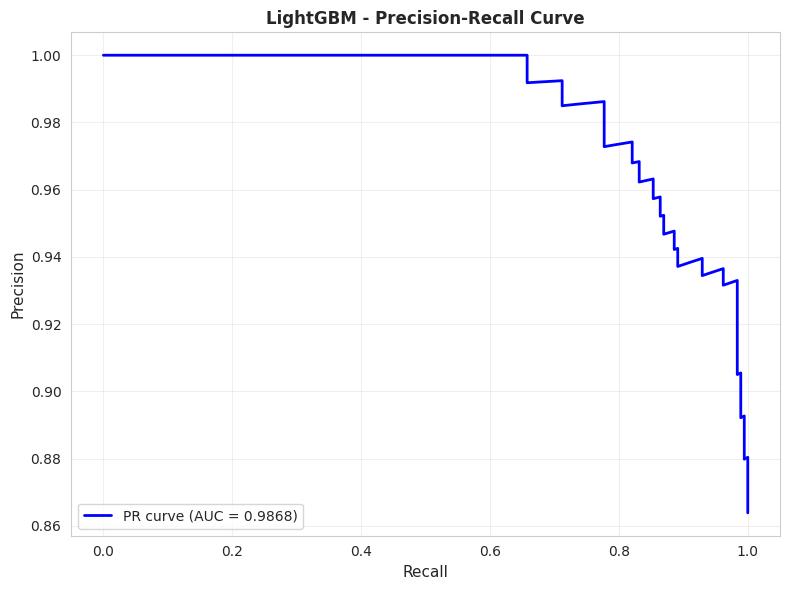


CatBoost Evaluation (Binary Classification)

Classification Report:
              precision    recall  f1-score   support

     Class 0     0.4528    0.8276    0.5854        29
     Class 1     0.9688    0.8424    0.9012       184

    accuracy                         0.8404       213
   macro avg     0.7108    0.8350    0.7433       213
weighted avg     0.8985    0.8404    0.8582       213


Detailed Metrics:
  Accuracy: 0.8404
  F1 Score (macro): 0.7433
  F1 Score (weighted): 0.8582
  F1 Score (binary, pos_label=1): 0.9012
  Precision (Class 1): 0.9688
  Recall/Sensitivity (Class 1): 0.8424
  ROC AUC Score: 0.9074

Confusion Matrix Metrics:
  True Negatives (TN): 24
  False Positives (FP): 5
  False Negatives (FN): 29
  True Positives (TP): 155
  Sensitivity (Recall): 0.8424
  Specificity: 0.8276


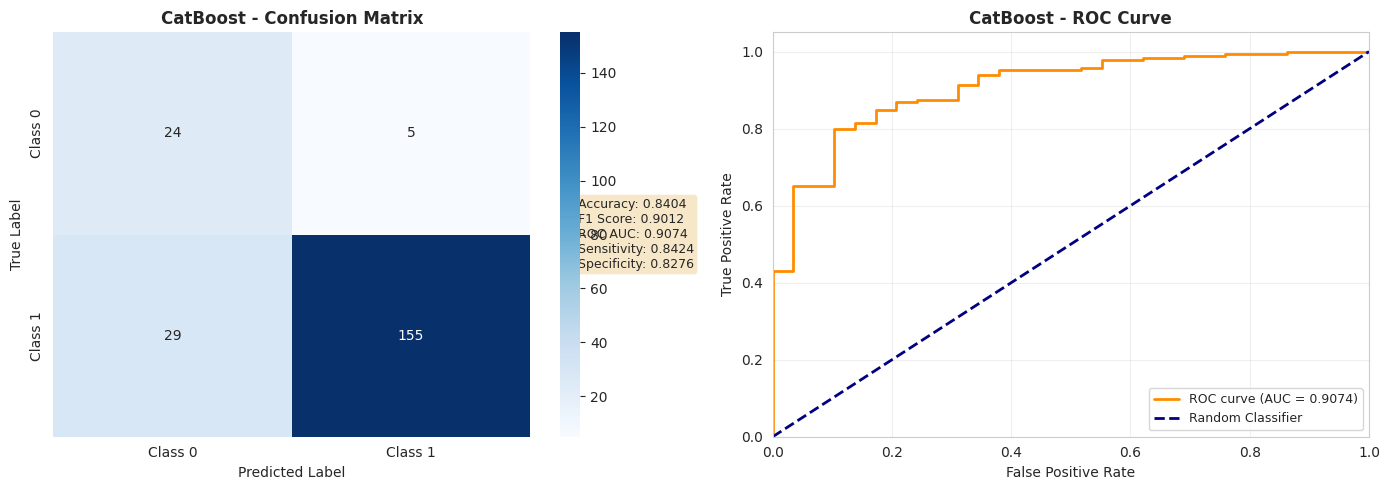

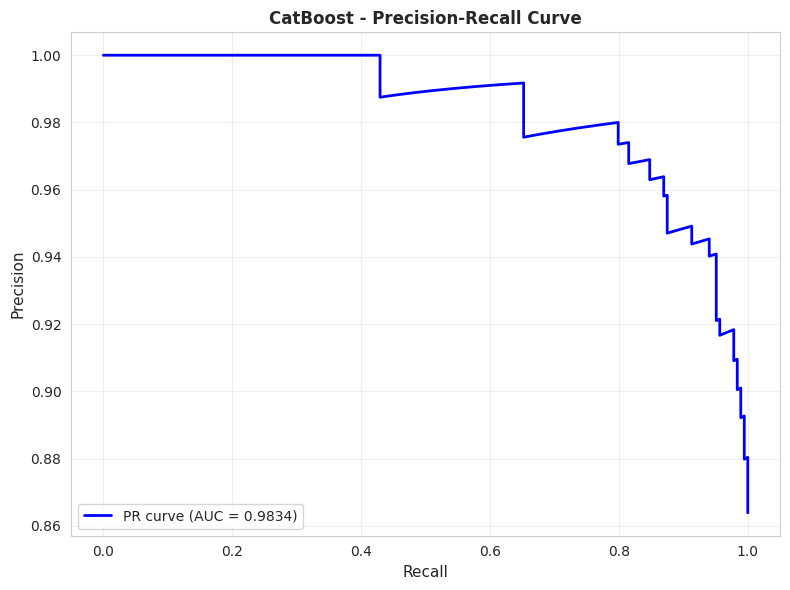


SUMMARY: Model Performance Comparison (Binary Classification)
Model           Accuracy   F1 (Binary)  ROC AUC    PR AUC     Sensitivity  Specificity 
--------------------------------------------------------------------------------
XGBoost         0.8310     0.8935       0.9084     0.9839     0.8207       0.8966      
LightGBM        0.8404     0.9023       0.9202     0.9868     0.8533       0.7586      
CatBoost        0.8404     0.9012       0.9074     0.9834     0.8424       0.8276      

Best Model (by ROC AUC): LightGBM (ROC AUC = 0.9202)


In [33]:
# --- 3.5. Evaluate Individual Boosting Models (Binary Classification) ---
print("="*80)
print("EVALUATING INDIVIDUAL BOOSTING MODELS (BINARY CLASSIFICATION)")
print("="*80)

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, precision_recall_curve, auc

models = {
    'XGBoost': xgb_clf,
    'LightGBM': lgbm_clf,
    'CatBoost': cat_clf
}

# Store results for comparison
individual_results = {}

for model_name, model in models.items():
    print(f"\n{'='*80}")
    print(f"{model_name} Evaluation (Binary Classification)")
    print(f"{'='*80}")
    
    # Make predictions
    y_pred = model.predict(X_test_selected)
    y_pred_proba = model.predict_proba(X_test_selected)
    
    # For binary classification, get probabilities for positive class (class 1)
    y_pred_proba_positive = y_pred_proba[:, 1] if y_pred_proba.shape[1] > 1 else y_pred_proba[:, 0]
    
    # Classification Report (binary classification)
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred, 
                              target_names=['Class 0', 'Class 1'],
                              digits=4))
    
    # Calculate binary classification metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    f1_binary = f1_score(y_test, y_pred, pos_label=1)
    precision = precision_score(y_test, y_pred, pos_label=1)
    recall = recall_score(y_test, y_pred, pos_label=1)
    
    # ROC AUC Score for binary classification
    roc_auc = roc_auc_score(y_test, y_pred_proba_positive)
    
    print(f"\nDetailed Metrics:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  F1 Score (macro): {f1_macro:.4f}")
    print(f"  F1 Score (weighted): {f1_weighted:.4f}")
    print(f"  F1 Score (binary, pos_label=1): {f1_binary:.4f}")
    print(f"  Precision (Class 1): {precision:.4f}")
    print(f"  Recall/Sensitivity (Class 1): {recall:.4f}")
    print(f"  ROC AUC Score: {roc_auc:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Calculate additional metrics from confusion matrix
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    print(f"\nConfusion Matrix Metrics:")
    print(f"  True Negatives (TN): {tn}")
    print(f"  False Positives (FP): {fp}")
    print(f"  False Negatives (FN): {fn}")
    print(f"  True Positives (TP): {tp}")
    print(f"  Sensitivity (Recall): {sensitivity:.4f}")
    print(f"  Specificity: {specificity:.4f}")
    
    # Visualize confusion matrix and ROC curve
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Confusion Matrix Heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Class 0', 'Class 1'], 
                yticklabels=['Class 0', 'Class 1'],
                ax=axes[0])
    axes[0].set_title(f'{model_name} - Confusion Matrix', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Predicted Label', fontsize=10)
    axes[0].set_ylabel('True Label', fontsize=10)
    
    # Add metrics text
    metrics_text = f'Accuracy: {accuracy:.4f}\n'
    metrics_text += f'F1 Score: {f1_binary:.4f}\n'
    metrics_text += f'ROC AUC: {roc_auc:.4f}\n'
    metrics_text += f'Sensitivity: {sensitivity:.4f}\n'
    metrics_text += f'Specificity: {specificity:.4f}'
    axes[0].text(1.1, 0.5, metrics_text, transform=axes[0].transAxes,
                fontsize=9, verticalalignment='center',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
    
    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_positive)
    axes[1].plot(fpr, tpr, color='darkorange', lw=2, 
                label=f'ROC curve (AUC = {roc_auc:.4f})')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
                label='Random Classifier')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('False Positive Rate', fontsize=10)
    axes[1].set_ylabel('True Positive Rate', fontsize=10)
    axes[1].set_title(f'{model_name} - ROC Curve', fontsize=12, fontweight='bold')
    axes[1].legend(loc="lower right", fontsize=9)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Precision-Recall Curve
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_test, y_pred_proba_positive)
    pr_auc = auc(recall_curve, precision_curve)
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall_curve, precision_curve, color='blue', lw=2, 
            label=f'PR curve (AUC = {pr_auc:.4f})')
    plt.xlabel('Recall', fontsize=11)
    plt.ylabel('Precision', fontsize=11)
    plt.title(f'{model_name} - Precision-Recall Curve', fontsize=12, fontweight='bold')
    plt.legend(loc="lower left", fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Store results
    individual_results[model_name] = {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'f1_binary': f1_binary,
        'precision': precision,
        'recall': recall,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'confusion_matrix': cm,
        'predictions': y_pred
    }

# Summary comparison
print(f"\n{'='*80}")
print("SUMMARY: Model Performance Comparison (Binary Classification)")
print(f"{'='*80}")
print(f"{'Model':<15} {'Accuracy':<10} {'F1 (Binary)':<12} {'ROC AUC':<10} {'PR AUC':<10} {'Sensitivity':<12} {'Specificity':<12}")
print("-" * 80)
for model_name, results in individual_results.items():
    print(f"{model_name:<15} {results['accuracy']:<10.4f} {results['f1_binary']:<12.4f} "
          f"{results['roc_auc']:<10.4f} {results['pr_auc']:<10.4f} "
          f"{results['sensitivity']:<12.4f} {results['specificity']:<12.4f}")

# Find best model based on ROC AUC
best_model_name = max(individual_results.items(), key=lambda x: x[1]['roc_auc'])[0]
print(f"\nBest Model (by ROC AUC): {best_model_name} (ROC AUC = {individual_results[best_model_name]['roc_auc']:.4f})")

### Model Evaluation


Evaluating the ensemble model on the test set (Binary Classification)...

Classification Report:
              precision    recall  f1-score   support

     Class 0     0.4423    0.7931    0.5679        29
     Class 1     0.9627    0.8424    0.8986       184

    accuracy                         0.8357       213
   macro avg     0.7025    0.8177    0.7332       213
weighted avg     0.8919    0.8357    0.8535       213


Confusion Matrix Structure:
  [TN=23  FP=6]  <- Class 0 row
  [FN=29  TP=155]  <- Class 1 row

Interpretation:
  TN (True Negatives): 23 - Class 0 correctly predicted as Class 0
  FP (False Positives): 6 - Class 0 incorrectly predicted as Class 1
  FN (False Negatives): 29 - Class 1 incorrectly predicted as Class 0
  TP (True Positives): 155 - Class 1 correctly predicted as Class 1

Detailed Metrics:
  Accuracy: 0.8357
  F1 Score (macro): 0.7332
  F1 Score (weighted): 0.8535
  F1 Score (binary, pos_label=1): 0.8986

  Class 0 Metrics:
    Precision: 0.4423 (from sklear

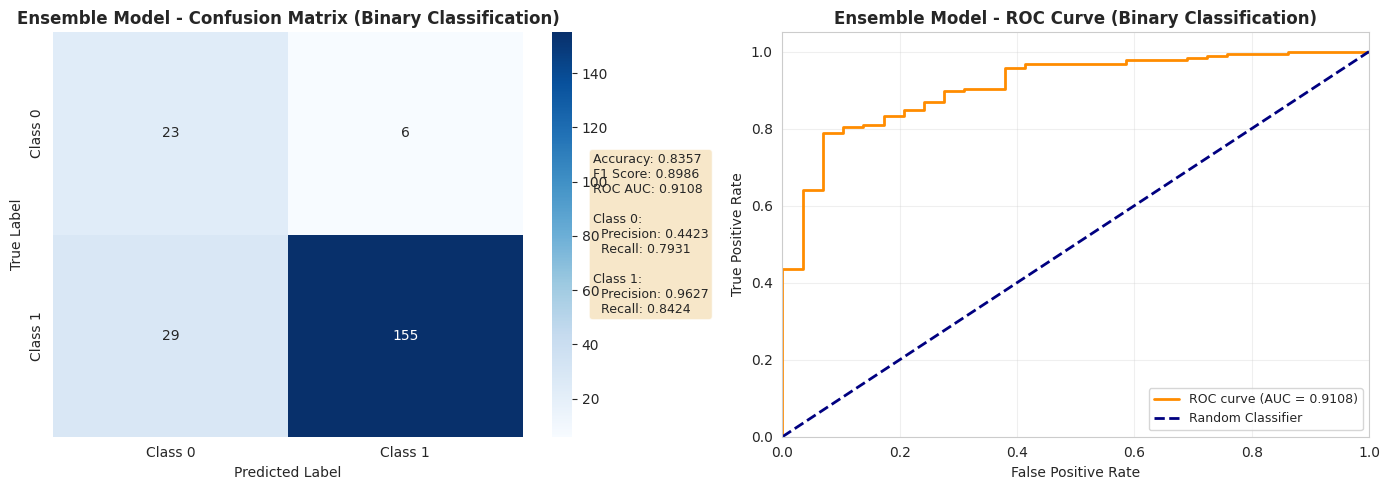

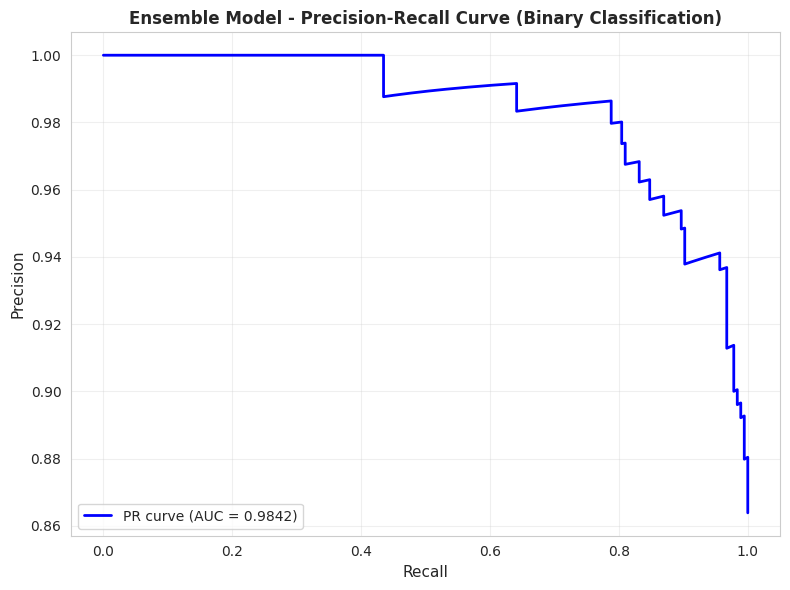


ENSEMBLE MODEL SUMMARY
Final Model Performance:
  Accuracy: 0.8357
  F1 Score (binary): 0.8986
  ROC AUC: 0.9108
  PR AUC: 0.9842

  Class 0:
    Precision: 0.4423
    Recall (Specificity): 0.7931

  Class 1:
    Precision: 0.9627
    Recall (Sensitivity): 0.8424


In [34]:
# --- 4. Evaluate the Ensemble Model (Binary Classification) ---
print("Evaluating the ensemble model on the test set (Binary Classification)...")

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, precision_recall_curve, auc

y_pred = ensemble_clf.predict(X_test_selected)
y_pred_proba = ensemble_clf.predict_proba(X_test_selected)

# For binary classification, get probabilities for positive class (class 1)
y_pred_proba_positive = y_pred_proba[:, 1] if y_pred_proba.shape[1] > 1 else y_pred_proba[:, 0]

# Classification Report (binary classification - no inverse transform needed)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, 
                          target_names=['Class 0', 'Class 1'],
                          digits=4))

# Confusion Matrix - calculate first to verify structure
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# Verify confusion matrix structure
print(f"\nConfusion Matrix Structure:")
print(f"  [TN={tn}  FP={fp}]  <- Class 0 row")
print(f"  [FN={fn}  TP={tp}]  <- Class 1 row")
print(f"\nInterpretation:")
print(f"  TN (True Negatives): {tn} - Class 0 correctly predicted as Class 0")
print(f"  FP (False Positives): {fp} - Class 0 incorrectly predicted as Class 1")
print(f"  FN (False Negatives): {fn} - Class 1 incorrectly predicted as Class 0")
print(f"  TP (True Positives): {tp} - Class 1 correctly predicted as Class 1")

# Calculate binary classification metrics for both classes
accuracy = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')
f1_binary = f1_score(y_test, y_pred, pos_label=1)

# Precision for both classes
precision_class0 = precision_score(y_test, y_pred, pos_label=0, zero_division=0)
precision_class1 = precision_score(y_test, y_pred, pos_label=1, zero_division=0)

# Recall for both classes
recall_class0 = recall_score(y_test, y_pred, pos_label=0, zero_division=0)
recall_class1 = recall_score(y_test, y_pred, pos_label=1, zero_division=0)

# Calculate from confusion matrix to verify
precision_class0_from_cm = tn / (tn + fn) if (tn + fn) > 0 else 0
precision_class1_from_cm = tp / (tp + fp) if (tp + fp) > 0 else 0
recall_class0_from_cm = tn / (tn + fp) if (tn + fp) > 0 else 0
recall_class1_from_cm = tp / (tp + fn) if (tp + fn) > 0 else 0

# ROC AUC Score for binary classification
roc_auc = roc_auc_score(y_test, y_pred_proba_positive)

# Calculate additional metrics from confusion matrix
sensitivity = recall_class1_from_cm  # Same as recall for Class 1
specificity = recall_class0_from_cm  # Same as recall for Class 0

print(f"\nDetailed Metrics:")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  F1 Score (macro): {f1_macro:.4f}")
print(f"  F1 Score (weighted): {f1_weighted:.4f}")
print(f"  F1 Score (binary, pos_label=1): {f1_binary:.4f}")
print(f"\n  Class 0 Metrics:")
print(f"    Precision: {precision_class0:.4f} (from sklearn)")
print(f"    Precision: {precision_class0_from_cm:.4f} (from CM: TN/(TN+FN))")
print(f"    Recall: {recall_class0:.4f} (from sklearn)")
print(f"    Recall: {recall_class0_from_cm:.4f} (from CM: TN/(TN+FP))")
print(f"\n  Class 1 Metrics:")
print(f"    Precision: {precision_class1:.4f} (from sklearn)")
print(f"    Precision: {precision_class1_from_cm:.4f} (from CM: TP/(TP+FP))")
print(f"    Recall/Sensitivity: {recall_class1:.4f} (from sklearn)")
print(f"    Recall/Sensitivity: {recall_class1_from_cm:.4f} (from CM: TP/(TP+FN))")
print(f"\n  ROC AUC Score: {roc_auc:.4f}")

print(f"\nConfusion Matrix Metrics:")
print(f"  True Negatives (TN): {tn} - Class 0 correctly predicted")
print(f"  False Positives (FP): {fp} - Class 0 mispredicted as Class 1")
print(f"  False Negatives (FN): {fn} - Class 1 mispredicted as Class 0")
print(f"  True Positives (TP): {tp} - Class 1 correctly predicted")
print(f"  Sensitivity (Recall for Class 1): {sensitivity:.4f}")
print(f"  Specificity (Recall for Class 0): {specificity:.4f}")

# Visualize confusion matrix and ROC curve
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1'], 
            yticklabels=['Class 0', 'Class 1'],
            ax=axes[0])
axes[0].set_title('Ensemble Model - Confusion Matrix (Binary Classification)', 
                 fontsize=12, fontweight='bold')
axes[0].set_xlabel('Predicted Label', fontsize=10)
axes[0].set_ylabel('True Label', fontsize=10)

# Add metrics text with both classes
metrics_text = f'Accuracy: {accuracy:.4f}\n'
metrics_text += f'F1 Score: {f1_binary:.4f}\n'
metrics_text += f'ROC AUC: {roc_auc:.4f}\n'
metrics_text += f'\nClass 0:\n'
metrics_text += f'  Precision: {precision_class0:.4f}\n'
metrics_text += f'  Recall: {recall_class0:.4f}\n'
metrics_text += f'\nClass 1:\n'
metrics_text += f'  Precision: {precision_class1:.4f}\n'
metrics_text += f'  Recall: {recall_class1:.4f}'
axes[0].text(1.15, 0.5, metrics_text, transform=axes[0].transAxes,
            fontsize=9, verticalalignment='center',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_positive)
axes[1].plot(fpr, tpr, color='darkorange', lw=2, 
            label=f'ROC curve (AUC = {roc_auc:.4f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
            label='Random Classifier')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate', fontsize=10)
axes[1].set_ylabel('True Positive Rate', fontsize=10)
axes[1].set_title('Ensemble Model - ROC Curve (Binary Classification)', 
                 fontsize=12, fontweight='bold')
axes[1].legend(loc="lower right", fontsize=9)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Precision-Recall Curve
precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_test, y_pred_proba_positive)
pr_auc = auc(recall_curve, precision_curve)

plt.figure(figsize=(8, 6))
plt.plot(recall_curve, precision_curve, color='blue', lw=2, 
        label=f'PR curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall', fontsize=11)
plt.ylabel('Precision', fontsize=11)
plt.title('Ensemble Model - Precision-Recall Curve (Binary Classification)', 
         fontsize=12, fontweight='bold')
plt.legend(loc="lower left", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n{'='*80}")
print("ENSEMBLE MODEL SUMMARY")
print(f"{'='*80}")
print(f"Final Model Performance:")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  F1 Score (binary): {f1_binary:.4f}")
print(f"  ROC AUC: {roc_auc:.4f}")
print(f"  PR AUC: {pr_auc:.4f}")
print(f"\n  Class 0:")
print(f"    Precision: {precision_class0:.4f}")
print(f"    Recall (Specificity): {recall_class0:.4f}")
print(f"\n  Class 1:")
print(f"    Precision: {precision_class1:.4f}")
print(f"    Recall (Sensitivity): {recall_class1:.4f}")
print(f"{'='*80}")

## Model 2.1 Ensemble Modeling (TabNet + Boosting Models with Meta-Learner)

In [ ]:

# =============================================================================
# STACKING ENSEMBLE: TabNet + Boosting Models with Meta-Learner
# =============================================================================

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (classification_report, confusion_matrix, 
                             accuracy_score, f1_score, roc_auc_score)
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from pytorch_tabnet.tab_model import TabNetClassifier
from imblearn.combine import SMOTEENN


class StackingConfig:
    """Configuration for the stacking ensemble"""
    N_FOLDS = 5  # Number of folds for out-of-fold predictions
    RANDOM_STATE = 42
    
    TABNET_PARAMS = {
        'n_d': 8, 'n_a': 8, 'n_steps': 4, 'gamma': 1.3,
        'n_independent': 2, 'n_shared': 2, 'lambda_sparse': 0.005,
        'mask_type': 'entmax', 'verbose': 0, 'seed': 42
    }


class TabNetWrapper:
    """Wrapper for TabNet - trains on original data without resampling"""
    def __init__(self, params, focal_loss_fn=None):
        self.params = params
        self.focal_loss_fn = focal_loss_fn
        self.model = None
        
    def fit(self, X, y, X_val=None, y_val=None):
        self.model = TabNetClassifier(**self.params)

        # Ensure all data passed to TabNet are NumPy arrays
        X_np = X.values if isinstance(X, pd.DataFrame) else X
        X_val_np = X_val.values if isinstance(X_val, pd.DataFrame) else X_val
        
        eval_set = [(X_val_np, y_val)] if X_val_np is not None and y_val is not None else None
        
        self.model.fit(
            X_np, y,
            eval_set=eval_set, max_epochs=200, patience=15,
            batch_size=64, virtual_batch_size=16,
            loss_fn=self.focal_loss_fn, weights=0
        )
        return self
    
    def predict_proba(self, X):
        X_arr = X.values if isinstance(X, pd.DataFrame) else X
        return self.model.predict_proba(X_arr)


class BoostingModelWrapper:
    """Wrapper for boosting models - applies SMOTE-ENN resampling"""
    def __init__(self, model_class, params, apply_resampling=True):
        self.model_class = model_class
        self.params = params
        self.apply_resampling = apply_resampling
        self.model = None
        self.resampler = SMOTEENN(random_state=42) if apply_resampling else None
        
    def fit(self, X, y):
        if self.apply_resampling and self.resampler is not None:
            X_res, y_res = self.resampler.fit_resample(X, y)
        else:
            X_res, y_res = X, y
            
        self.model = self.model_class(**self.params)
        self.model.fit(X_res, y_res)
        return self
    
    def predict_proba(self, X):
        return self.model.predict_proba(X)



def generate_oof_predictions(models_dict, X_train, y_train, 
                             X_train_tabnet, n_folds=5, random_state=42):
    """
    Generate out-of-fold predictions for all base models.
    """
    n_samples = len(y_train)
    oof_probs = {name: np.zeros(n_samples) for name in models_dict.keys()}
    
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_state)
    
    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
        print(f"\nFold {fold_idx + 1}/{n_folds}")
        
        # Split data for this fold
        X_fold_train = X_train.iloc[train_idx] if hasattr(X_train, 'iloc') else X_train[train_idx]
        X_fold_val = X_train.iloc[val_idx] if hasattr(X_train, 'iloc') else X_train[val_idx]
        y_fold_train = y_train[train_idx]
        
        # Split TabNet features
        X_fold_train_tabnet = X_train_tabnet.iloc[train_idx] if hasattr(X_train_tabnet, 'iloc') else X_train_tabnet[train_idx]
        X_fold_val_tabnet = X_train_tabnet.iloc[val_idx] if hasattr(X_train_tabnet, 'iloc') else X_train_tabnet[val_idx]
        y_fold_val = y_train[val_idx]

        # Train each model and predict on validation fold
        for model_name, model_config in models_dict.items():
            print(f"  Training {model_name}...")
            if model_config.get('uses_tabnet_features', False):
                # TabNet: feature-selected data, no resampling
                wrapper = model_config['wrapper_class'](**model_config['params'])
                wrapper.fit(X_fold_train_tabnet, y_fold_train, X_fold_val_tabnet, y_fold_val)
                proba = wrapper.predict_proba(X_fold_val_tabnet)
            else:
                # Boosting: full features, with resampling
                wrapper = model_config['wrapper_class'](**model_config['params'])
                wrapper.fit(X_fold_train, y_fold_train)
                proba = wrapper.predict_proba(X_fold_val)
            
            oof_probs[model_name][val_idx] = proba[:, 1]
    
    # Train final models on full data for test predictions
    print("\nTraining final base models on full training data...")
    trained_models = {}
    for model_name, model_config in models_dict.items():
        print(f"  Training final {model_name}...")
        if model_config.get('uses_tabnet_features', False):
            wrapper = model_config['wrapper_class'](**model_config['params'])
            wrapper.fit(X_train_tabnet, y_train)
        else:
            wrapper = model_config['wrapper_class'](**model_config['params'])
            wrapper.fit(X_train, y_train)
        
        trained_models[model_name] = {
            'model': wrapper,
            'uses_tabnet_features': model_config.get('uses_tabnet_features', False)
        }
    
    return pd.DataFrame(oof_probs), trained_models


class MetaLearner:
    """Meta-learner with probability calibration"""
    def __init__(self, meta_model_type='logistic', calibrate=True):
        self.meta_model_type = meta_model_type
        self.calibrate = calibrate
        self.meta_model = None
        
    def fit(self, X_meta, y):
        if self.meta_model_type == 'logistic':
            base_model = LogisticRegression(
                C=1.0, class_weight='balanced', max_iter=1000, random_state=42
            )
        elif self.meta_model_type == 'xgboost':
            base_model = xgb.XGBClassifier(
                n_estimators=50, max_depth=3, learning_rate=0.1, random_state=42
            )
        
        if self.calibrate:
            self.meta_model = CalibratedClassifierCV(
                base_model, method='isotonic', cv=3
            )
        else:
            self.meta_model = base_model
            
        self.meta_model.fit(X_meta, y)
        return self
    
    def predict_proba(self, X_meta):
        return self.meta_model.predict_proba(X_meta)
    
    def predict(self, X_meta):
        return self.meta_model.predict(X_meta)




Fold 1/5
  Training TabNet...

Early stopping occurred at epoch 46 with best_epoch = 31 and best_val_0_auc = 0.6983
  Training XGBoost...
  Training LightGBM...
  Training CatBoost...

Fold 2/5
  Training TabNet...

Early stopping occurred at epoch 15 with best_epoch = 0 and best_val_0_auc = 0.61077
  Training XGBoost...
  Training LightGBM...
  Training CatBoost...

Fold 3/5
  Training TabNet...

Early stopping occurred at epoch 37 with best_epoch = 22 and best_val_0_auc = 0.68057
  Training XGBoost...
  Training LightGBM...
  Training CatBoost...

Fold 4/5
  Training TabNet...

Early stopping occurred at epoch 20 with best_epoch = 5 and best_val_0_auc = 0.70807
  Training XGBoost...
  Training LightGBM...
  Training CatBoost...

Fold 5/5
  Training TabNet...

Early stopping occurred at epoch 42 with best_epoch = 27 and best_val_0_auc = 0.60663
  Training XGBoost...
  Training LightGBM...
  Training CatBoost...

Training final base models on full training data...
  Training final Tab

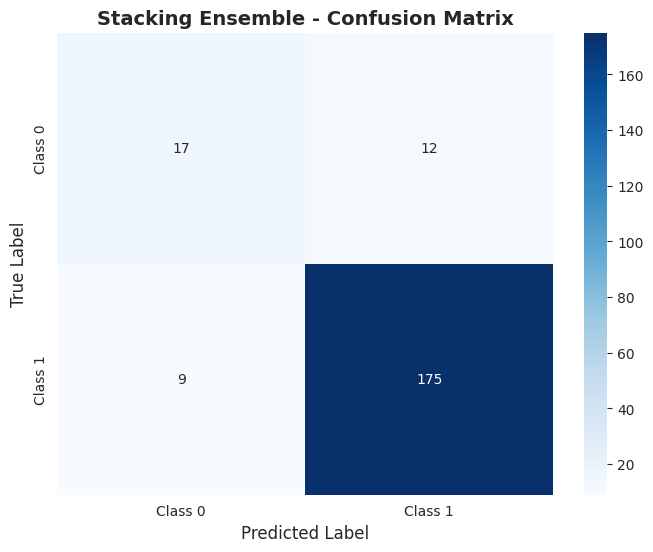

In [ ]:
# --- STEP 1: Set up model configurations ---
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight

# Ensure y_train is a numpy array for consistent indexing
y_train_np = y_train.values if isinstance(y_train, pd.Series) else y_train


counter = Counter(y_train_np)
scale_pos_weight = counter[0] / counter[1] if counter[1] > 0 else 1
class_weights_calc = compute_class_weight('balanced', classes=np.unique(y_train_np), y=y_train_np)
cat_weights = dict(zip(np.unique(y_train_np), class_weights_calc))

models_dict = {
    'TabNet': {
        'wrapper_class': TabNetWrapper,
        'params': {'params': StackingConfig.TABNET_PARAMS, 'focal_loss_fn': focal_loss_fn},
        'uses_tabnet_features': True
    },
    'XGBoost': {
        'wrapper_class': BoostingModelWrapper,
        'params': {
            'model_class': xgb.XGBClassifier,
            'params': {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'use_label_encoder': False, 'scale_pos_weight': scale_pos_weight, 'n_estimators': 100, 'random_state': 42},
            'apply_resampling': True
        },
        'uses_tabnet_features': False
    },
    'LightGBM': {
        'wrapper_class': BoostingModelWrapper,
        'params': {
            'model_class': lgb.LGBMClassifier,
            'params': {'objective': 'binary', 'class_weight': 'balanced', 'n_estimators': 100, 'verbose': -1, 'random_state': 42},
            'apply_resampling': True
        },
        'uses_tabnet_features': False
    },
    'CatBoost': {
        'wrapper_class': BoostingModelWrapper,
        'params': {
            'model_class': cb.CatBoostClassifier,
            'params': {'class_weights': cat_weights, 'iterations': 100, 'verbose': 0, 'loss_function': 'Logloss', 'random_state': 42},
            'apply_resampling': True
        },
        'uses_tabnet_features': False
    }
}

# TabNet uses X_train_selected (feature-selected, no resampling)
# Boosting models use X_train (full features, but will be resampled inside the wrapper)
oof_predictions, trained_models = generate_oof_predictions(
    models_dict, X_train, y_train_np, X_train_selected,
    n_folds=StackingConfig.N_FOLDS, random_state=StackingConfig.RANDOM_STATE
)

print("\nTraining the meta-learner...")
meta_learner = MetaLearner(meta_model_type='logistic', calibrate=True)
meta_learner.fit(oof_predictions, y_train_np)
print("Meta-learner training complete.")

print("\nGenerating predictions on the test set...")
test_probs = {}
for model_name, model_info in trained_models.items():
    if model_info['uses_tabnet_features']:
        proba = model_info['model'].predict_proba(X_test_selected)
    else:
        # Note: Use the original X_test for boosting models as they expect full features
        proba = model_info['model'].predict_proba(X_test)
    test_probs[model_name] = proba[:, 1]

X_meta_test = pd.DataFrame(test_probs)
y_pred_proba = meta_learner.predict_proba(X_meta_test)[:, 1]
y_pred = (y_pred_proba >= 0.5).astype(int)

# --- STEP 5: Evaluate ---
print("\n" + "="*80)
print("Final Stacking Ensemble Evaluation")
print("="*80)
print(f"Stacking Ensemble ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1'], 
            yticklabels=['Class 0', 'Class 1'])
plt.title('Stacking Ensemble - Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()



### Improving Class 0 Performance

STAGE 1: Finding optimal threshold...
Optimal Threshold (from F1-score): 0.3797

Stage 1 Results (Threshold Tuning):
              precision    recall  f1-score   support

     Class 0     0.7143    0.5172    0.6000        29
     Class 1     0.9271    0.9674    0.9468       184

    accuracy                         0.9061       213
   macro avg     0.8207    0.7423    0.7734       213
weighted avg     0.8981    0.9061    0.8996       213



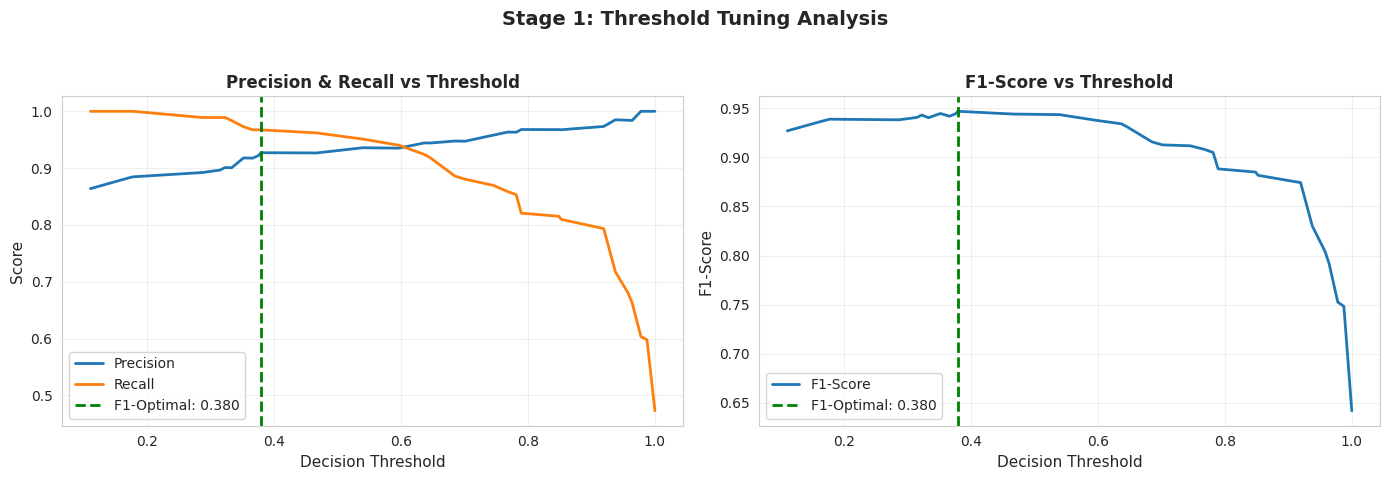


STAGE 2: Retraining meta-learner with class weights...
Meta-learner: Custom weights (2.5x for Class 0)
Applied Threshold: 0.40

Stage 2 Results (Class Weights + Threshold):
              precision    recall  f1-score   support

     Class 0     0.6818    0.5172    0.5882        29
     Class 1     0.9267    0.9620    0.9440       184

    accuracy                         0.9014       213
   macro avg     0.8043    0.7396    0.7661       213
weighted avg     0.8934    0.9014    0.8956       213


STAGE 3: Using XGBoost meta-learner...
Meta-learner: XGBoost (scale_pos_weight: 3.5)
Applied Threshold: 0.35

Stage 3 Results (XGBoost Meta-Learner + Threshold):
              precision    recall  f1-score   support

     Class 0     0.8333    0.1724    0.2857        29
     Class 1     0.8841    0.9946    0.9361       184

    accuracy                         0.8826       213
   macro avg     0.8587    0.5835    0.6109       213
weighted avg     0.8772    0.8826    0.8475       213



COMPARI

In [ ]:
# =============================================================================
# 3-Stage Optimization to Improve Class 0 Recall
# =============================================================================

from sklearn.metrics import precision_recall_curve, f1_score, recall_score, precision_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

# Use the final probability predictions from the original stacking ensemble

# STAGE 1: Threshold Tuning (easiest)
print("="*80)
print("STAGE 1: Finding optimal threshold...")
print("="*80)

precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Calculate F1-score for each threshold. Add a small epsilon to avoid division by zero.
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)

# Find the threshold that maximizes F1-score for the positive class (Class 1)
f1_optimal_idx = np.argmax(f1_scores[:-1])
threshold_1 = thresholds[f1_optimal_idx]
y_pred_1 = (y_pred_proba >= threshold_1).astype(int)

print(f"Optimal Threshold (from F1-score): {threshold_1:.4f}")
print("\nStage 1 Results (Threshold Tuning):")
print(classification_report(y_test, y_pred_1, target_names=['Class 0', 'Class 1'], digits=4))


# Visualize threshold impact
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Stage 1: Threshold Tuning Analysis', fontsize=14, fontweight='bold')

# Precision-Recall Curve vs Threshold
axes[0].plot(thresholds, precisions[:-1], label='Precision', linewidth=2)
axes[0].plot(thresholds, recalls[:-1], label='Recall', linewidth=2)
axes[0].axvline(threshold_1, color='green', linestyle='--', linewidth=2, 
                label=f'F1-Optimal: {threshold_1:.3f}')
axes[0].set_xlabel('Decision Threshold', fontsize=11)
axes[0].set_ylabel('Score', fontsize=11)
axes[0].set_title('Precision & Recall vs Threshold', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# F1-Score vs Threshold
axes[1].plot(thresholds, f1_scores[:-1], label='F1-Score', linewidth=2)
axes[1].axvline(threshold_1, color='green', linestyle='--', linewidth=2,
                label=f'F1-Optimal: {threshold_1:.3f}')
axes[1].set_xlabel('Decision Threshold', fontsize=11)
axes[1].set_ylabel('F1-Score', fontsize=11)
axes[1].set_title('F1-Score vs Threshold', fontsize=12, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Add class weighting to meta-learner
print("\n" + "="*80)
print("STAGE 2: Retraining meta-learner with class weights...")
print("="*80)
meta_learner_weighted = CalibratedClassifierCV(
    LogisticRegression(class_weight={0: 2.5, 1: 1.0}, C=1.0, 
                      max_iter=1000, random_state=42),
    method='isotonic', cv=3
)
meta_learner_weighted.fit(oof_predictions, y_train_np)
y_pred_proba_2 = meta_learner_weighted.predict_proba(X_meta_test)[:, 1]
# Apply a slightly adjusted threshold
threshold_2 = 0.40
y_pred_2 = (y_pred_proba_2 >= threshold_2).astype(int)

print(f"Meta-learner: Custom weights (2.5x for Class 0)\nApplied Threshold: {threshold_2:.2f}")
print("\nStage 2 Results (Class Weights + Threshold):")
print(classification_report(y_test, y_pred_2, target_names=['Class 0', 'Class 1'], digits=4))


#  Use XGBoost meta-learner for maximum control
print("\n" + "="*80)
print("STAGE 3: Using XGBoost meta-learner...")
print("="*80)
meta_learner_xgb = xgb.XGBClassifier(
    n_estimators=50, max_depth=3, learning_rate=0.1,
    scale_pos_weight=3.5, # Heavy penalty for misclassifying the minority class (Class 0)
    random_state=42, verbosity=0, use_label_encoder=False, eval_metric='logloss'
)
meta_learner_xgb.fit(oof_predictions, y_train_np)
y_pred_proba_3 = meta_learner_xgb.predict_proba(X_meta_test)[:, 1]
# Apply another adjusted threshold
threshold_3 = 0.35
y_pred_3 = (y_pred_proba_3 >= threshold_3).astype(int)

print(f"Meta-learner: XGBoost (scale_pos_weight: 3.5)\nApplied Threshold: {threshold_3:.2f}")
print("\nStage 3 Results (XGBoost Meta-Learner + Threshold):")
print(classification_report(y_test, y_pred_3, target_names=['Class 0', 'Class 1'], digits=4))


# Compare all stages
print("\n\n" + "="*80)
print("COMPARISON: ALL STRATEGIES FOR IMPROVING CLASS 0 PERFORMANCE")
print("="*80)

# Original predictions are stored in y_pred from the previous cell
original_f1 = f1_score(y_test, y_pred, pos_label=0)
original_recall = recall_score(y_test, y_pred, pos_label=0)
original_precision = precision_score(y_test, y_pred, pos_label=0)

strategies_comparison = pd.DataFrame({
    'Strategy': ['Original (0.5 threshold)', 'Stage 1 (Threshold Tuning)', 
                 'Stage 2 (+ Class Weights)', 'Stage 3 (+ XGBoost)'],
    'Class_0_F1': [
        original_f1,
        f1_score(y_test, y_pred_1, pos_label=0),
        f1_score(y_test, y_pred_2, pos_label=0),
        f1_score(y_test, y_pred_3, pos_label=0)
    ],
    'Class_0_Recall': [
        original_recall,
        recall_score(y_test, y_pred_1, pos_label=0),
        recall_score(y_test, y_pred_2, pos_label=0),
        recall_score(y_test, y_pred_3, pos_label=0)
    ],
    'Class_0_Precision': [
        original_precision,
        precision_score(y_test, y_pred_1, pos_label=0),
        precision_score(y_test, y_pred_2, pos_label=0),
        precision_score(y_test, y_pred_3, pos_label=0)
    ]
})

print(strategies_comparison.to_string(index=False))



In [ ]:
##Final Model Comparison for Class 0 Performance


# Collect results from individual boosting models 
boosting_results = []
for model_name, results in individual_results.items():
    y_pred_model = results['predictions']
    boosting_results.append({
        'Model': model_name,
        'Class_0_F1': f1_score(y_test, y_pred_model, pos_label=0),
        'Class_0_Recall': recall_score(y_test, y_pred_model, pos_label=0),
        'Class_0_Precision': precision_score(y_test, y_pred_model, pos_label=0)
    })

# Collect results from TabNet model
tabnet_results = {
    'Model': 'TabNet',
    'Class_0_F1': f1_score(y_test, y_pred_tabnet, pos_label=0),
    'Class_0_Recall': recall_score(y_test, y_pred_tabnet, pos_label=0),
    'Class_0_Precision': precision_score(y_test, y_pred_tabnet, pos_label=0)
}

# Collect results from stacking strategies 
stacking_results = [
    {
        'Model': 'Stacking (Original)',
        'Class_0_F1': original_f1,
        'Class_0_Recall': original_recall,
        'Class_0_Precision': original_precision
    },
    {
        'Model': 'Stacking (Stage 1: Threshold)',
        'Class_0_F1': f1_score(y_test, y_pred_1, pos_label=0),
        'Class_0_Recall': recall_score(y_test, y_pred_1, pos_label=0),
        'Class_0_Precision': precision_score(y_test, y_pred_1, pos_label=0)
    },
    {
        'Model': 'Stacking (Stage 2: Weights)',
        'Class_0_F1': f1_score(y_test, y_pred_2, pos_label=0),
        'Class_0_Recall': recall_score(y_test, y_pred_2, pos_label=0),
        'Class_0_Precision': precision_score(y_test, y_pred_2, pos_label=0)
    },
    {
        'Model': 'Stacking (Stage 3: XGBoost Meta)',
        'Class_0_F1': f1_score(y_test, y_pred_3, pos_label=0),
        'Class_0_Recall': recall_score(y_test, y_pred_3, pos_label=0),
        'Class_0_Precision': precision_score(y_test, y_pred_3, pos_label=0)
    }
]

# Combine all results 
all_results = boosting_results + [tabnet_results] + stacking_results
comparison_df = pd.DataFrame(all_results)

# Display the final comparison table 
print("="*80)
print("Final Comparison of All Models - Class 0 Performance")
print("="*80)
print(comparison_df.to_string(index=False))



Final Comparison of All Models - Class 0 Performance
                           Model  Class_0_F1  Class_0_Recall  Class_0_Precision
                         XGBoost    0.590909        0.896552           0.440678
                        LightGBM    0.564103        0.758621           0.448980
                        CatBoost    0.585366        0.827586           0.452830
                          TabNet    0.600000        0.517241           0.714286
             Stacking (Original)    0.618182        0.586207           0.653846
   Stacking (Stage 1: Threshold)    0.600000        0.517241           0.714286
     Stacking (Stage 2: Weights)    0.588235        0.517241           0.681818
Stacking (Stage 3: XGBoost Meta)    0.285714        0.172414           0.833333


## 2.3 Ensemble learning (Dual Model Strategy)


We will use TWO complementary models:

**Model 1: XGBoost (Disease Detector)**
- **Purpose**: Screen for abnormalities with **HIGH SENSITIVITY** (high recall for Class 0).
- **Trained on**: SMOTE-ENN resampled data to handle class imbalance effectively.
- **Decision Threshold**: A lower threshold (e.g., if probability of *not* being Class 1 is high) will flag potential abnormalities.
- **Action**: If flagged, the case is sent to a specialist for immediate review.

**Model 2: Stacking Ensemble (Normality Classifier)**
- **Purpose**: Confirm normal cases with **HIGH SPECIFICITY** and overall accuracy.
- **Composed of**: TabNet + XGBoost + LightGBM + CatBoost as base models, with a Logistic Regression meta-learner.
- **Decision**: Used to confirm cases that are likely normal or to provide a secondary check on borderline cases.
- **Action**: High-confidence normal predictions can be auto-accepted, reducing specialist workload.

### Workflow:

Patient Data → 
              ↓
        XGBoost Screening
              ├─ If Prob(Class 1) < 0.6 (High chance of abnormality) → ABNORMAL (Send to Specialist)
              ├─ If 0.6 ≤ Prob(Class 1) ≤ 0.8 (Borderline) → Use Stacking for confirmation
              └─ If Prob(Class 1) > 0.8 (Likely Normal) → Use Stacking to confirm




In [ ]:
import pickle


print("Saving trained models...")
try:
    with open('xgboost_screener_model.pkl', 'wb') as f:
        pickle.dump(models['XGBoost'], f)

    with open('stacking_base_models.pkl', 'wb') as f:
        pickle.dump(trained_models, f)

    with open('stacking_meta_learner.pkl', 'wb') as f:
        pickle.dump(meta_learner, f)
    print("✓ Models saved successfully.")
except NameError as e:
    print(f"❌ ERROR: A model variable was not found. Please ensure all training cells have been run.")
    print(f"  > {e}")


print("\nSaving preprocessing objects...")
try:
    with open('feature_scaler.pkl', 'wb') as f:
        pickle.dump(scaler, f)

    with open('features_to_scale.pkl', 'wb') as f:
        pickle.dump(features_to_scale, f)

    with open('selected_features.pkl', 'wb') as f:
        pickle.dump(selected_features, f)
    print("✓ Preprocessing objects saved successfully.")
except NameError as e:
    print(f"❌ ERROR: A preprocessing variable was not found. Please ensure all data preparation cells have been run.")
    print(f"  > {e}")

print("\n--- Serialization Complete ---")



Saving trained models...
✓ Models saved successfully.

Saving preprocessing objects...
✓ Preprocessing objects saved successfully.

--- Serialization Complete ---


In [ ]:
import pickle
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')


components_loaded = True
missing_file = ""
try:
    files_to_load = [
        'xgboost_screener_model.pkl',
        'stacking_base_models.pkl',
        'stacking_meta_learner.pkl',
        'feature_scaler.pkl',
        'features_to_scale.pkl',
        'selected_features.pkl'
    ]
    
    # Loop through and load each file
    for filename in files_to_load:
        missing_file = filename
        with open(filename, 'rb') as f:
            # Use globals() to dynamically assign variable names
            globals()[filename.replace('.pkl', '_loaded')] = pickle.load(f)
            
    print("✓ All models and preprocessing objects loaded successfully.")

except FileNotFoundError:
    components_loaded = False
    print(f"❌ ERROR: The file '{missing_file}' was not found.")



if not components_loaded:
    raise RuntimeError(
        f"Could not load '{missing_file}'. This is usually caused by running cells out of order. "
        "Please re-run all cells from the top, then re-run the serialization cell "
        "('# SECTION 2: MODEL SERIALIZATION (SAVING)'), and finally this cell."
    )
else:
    print("✓ All deployment components verified.")
    xgboost_model = xgboost_screener_model_loaded
    stacking_base_models = stacking_base_models_loaded
    meta_learner_loaded = stacking_meta_learner_loaded
    scaler_loaded = feature_scaler_loaded
    features_to_scale_loaded = features_to_scale_loaded
    selected_features_loaded = selected_features_loaded


=

def preprocess_for_deployment(input_df, scaler, features_to_scale, all_feature_names, tabnet_feature_names):

    processed_df = input_df.copy()

    processed_df[features_to_scale] = scaler.transform(processed_df[features_to_scale])

    X_full_processed = processed_df[all_feature_names]
    X_tabnet_processed = X_full_processed[tabnet_feature_names]
    
    return X_full_processed, X_tabnet_processed



def classify_skin_lesion(X_full, X_tabnet, verbose=True):
    """
    Two-stage classification system for skin lesion analysis.
    """
    # STAGE 1: XGBoost SCREENING
    xgb_from_stacking = stacking_base_models['XGBoost']['model']
    xgb_prob = xgb_from_stacking.predict_proba(X_full)[0, 1]
    
    if verbose:
        print(f"[Stage 1] XGBoost Screening Prob(Class 1): {xgb_prob:.4f}")

    # Case 1A: High XGBoost confidence of abnormality (low prob of Class 1)
    if xgb_prob < 0.6:
        result = {
            'prediction': 'ABNORMAL',
            'confidence': 1 - xgb_prob,
            'action': 'SPECIALIST_REVIEW',
            'model_used': 'XGBoost (Stage 1)',
            'explanation': f"XGBoost detected high probability of abnormality ({1-xgb_prob:.1%})."
        }
        if verbose: print(f"  → ABNORMAL (Send to specialist)")
        return result

    # If not clearly abnormal, proceed to stacking for confirmation
    if verbose: print(f"  → Borderline or Normal, confirming with Stacking Ensemble...")

    # STAGE 2: STACKING ENSEMBLE PREDICTION
    test_probs = {}
    for model_name, model_info in stacking_base_models.items():
        if model_info['uses_tabnet_features']:
            proba = model_info['model'].predict_proba(X_tabnet)
        else:
            proba = model_info['model'].predict_proba(X_full)
        test_probs[model_name] = proba[:, 1]
    
    X_meta_test = pd.DataFrame(test_probs)
    stack_prob = meta_learner_loaded.predict_proba(X_meta_test)[0, 1]

    if verbose: print(f"[Stage 2] Stacking Ensemble Prob(Class 1): {stack_prob:.4f}")

    # Case 2A: Stacking confirms normality with high confidence
    if stack_prob > 0.8:
        result = {
            'prediction': 'NORMAL',
            'confidence': stack_prob,
            'action': 'AUTO_ACCEPT',
            'model_used': 'Stacking Ensemble (Confirmed Normal)',
            'explanation': f"Stacking ensemble confirmed normal with high confidence ({stack_prob:.1%})."
        }
        if verbose: print(f"    → NORMAL (Auto-accept)")
        return result
    else:
        # Case 2B: Stacking is not confident or detects abnormality
        result = {
            'prediction': 'ABNORMAL',
            'confidence': 1 - stack_prob,
            'action': 'SPECIALIST_REVIEW',
            'model_used': 'Stacking Ensemble (Secondary Check)',
            'explanation': f"Stacking ensemble could not confirm normality with high confidence (Prob(Normal) = {stack_prob:.1%})."
        }
        if verbose: print(f"    → ABNORMAL (Stacking override/confirmation)")
        return result


if components_loaded:
    # Simulate new patient data from the *unscaled*, but *feature-engineered* data.
    unscaled_patient_data = df_engineered.loc[[X_test.index[0]]].drop(columns=['Code', 'expire'])

    print("\n" + "="*80)
    print("Processing New Patient Data (Unscaled)")
    print("="*80)
    print("Input Features (first 5):")
    print(unscaled_patient_data.iloc[:, :5])

    # Preprocess the new data using the corrected pipeline
    X_full_proc, X_tabnet_proc = preprocess_for_deployment(
        unscaled_patient_data, 
        scaler_loaded, 
        features_to_scale=features_to_scale_loaded,
        all_feature_names=X_train.columns.tolist(),
        tabnet_feature_names=selected_features_loaded
    )

    # Get the final classification
    final_result = classify_skin_lesion(X_full_proc, X_tabnet_proc)

    print("\n" + "="*80)
    print("FINAL DECISION")
    print("="*80)
    print(f"Prediction: {final_result['prediction']}")
    print(f"Confidence: {final_result['confidence']:.1%}")
    print(f"Action: {final_result['action']}")
    print(f"Explanation: {final_result['explanation']}")



✓ All models and preprocessing objects loaded successfully.
✓ All deployment components verified.

Processing New Patient Data (Unscaled)
Input Features (first 5):
     sex  age  marital  career  residence
893    1   89        1       6          1
[Stage 1] XGBoost Screening Prob(Class 1): 0.0013
  → ABNORMAL (Send to specialist)

FINAL DECISION
Prediction: ABNORMAL
Confidence: 99.9%
Action: SPECIALIST_REVIEW
Explanation: XGBoost detected high probability of abnormality (99.9%).


Dual-model workflow predictions generated.

Comprehensive Evaluation of Final Dual-Model Workflow

Classification Report:
              precision    recall  f1-score   support

     Class 0     0.3571    0.8621    0.5051        29
     Class 1     0.9720    0.7554    0.8502       184

    accuracy                         0.7700       213
   macro avg     0.6646    0.8088    0.6776       213
weighted avg     0.8883    0.7700    0.8032       213


Detailed Metrics:
  Accuracy: 0.7700
  F1 Score (Macro): 0.6776

  Class 0 (Abnormal):
    - Precision: 0.3571
    - Recall:    0.8621

  Class 1 (Normal):
    - Precision: 0.9720
    - Recall:    0.7554


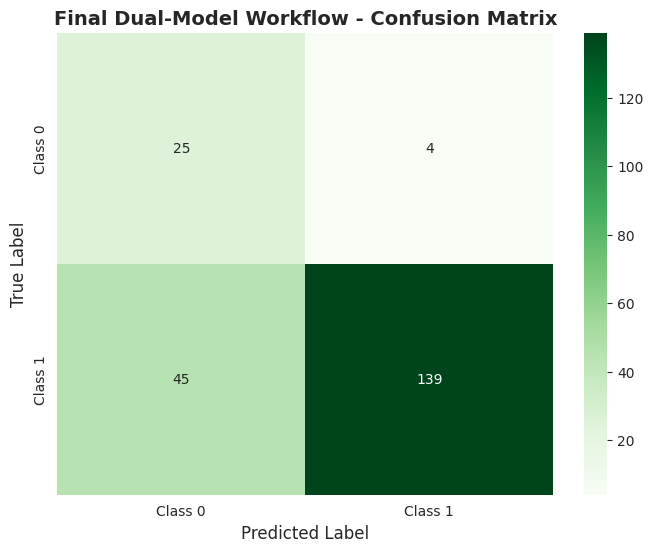


Final Solution Comparison - Class 0 Performance
              Model  Class_0_F1  Class_0_Recall  Class_0_Precision
            XGBoost    0.590909        0.896552           0.440678
Stacking (Original)    0.618182        0.586207           0.653846
Dual-Model Workflow    0.505051        0.862069           0.357143


In [ ]:
## Evaluation of the Final Dual-Model Solution

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score


# Get Stage 1 probabilities from the XGBoost screener (using the one from the stacking ensemble for consistency)
# This model expects the full feature set (X_test).
xgb_screener = stacking_base_models['XGBoost']['model']
xgb_probs_class1 = xgb_screener.predict_proba(X_test)[:, 1]

# Get Stage 2 probabilities from the full stacking ensemble meta-learner
# This uses the base model predictions on the test set (X_meta_test)
stack_probs_class1 = meta_learner_loaded.predict_proba(X_meta_test)[:, 1]

# Apply the dual-model logic across the entire test set
# Initialize predictions as 'NORMAL' (1) by default
y_pred_workflow = np.ones_like(y_test)

# Rule 1: If XGBoost screener is confident of abnormality (Prob(Class 1) < 0.6), predict ABNORMAL (0)
abnormal_condition = xgb_probs_class1 < 0.6
y_pred_workflow[abnormal_condition] = 0

# Rule 2: If XGBoost is not confident, but the Stacking model is not confident of normality (Prob(Class 1) <= 0.8), predict ABNORMAL (0)
borderline_condition = (xgb_probs_class1 >= 0.6) & (stack_probs_class1 <= 0.8)
y_pred_workflow[borderline_condition] = 0

print("Dual-model workflow predictions generated.")


print("\n" + "="*80)
print("Comprehensive Evaluation of Final Dual-Model Workflow")
print("="*80)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_workflow, 
                          target_names=['Class 0', 'Class 1'],
                          digits=4))

# Detailed Metrics
accuracy = accuracy_score(y_test, y_pred_workflow)
f1_macro = f1_score(y_test, y_pred_workflow, average='macro')
precision_c0 = precision_score(y_test, y_pred_workflow, pos_label=0)
recall_c0 = recall_score(y_test, y_pred_workflow, pos_label=0)
precision_c1 = precision_score(y_test, y_pred_workflow, pos_label=1)
recall_c1 = recall_score(y_test, y_pred_workflow, pos_label=1)

print(f"\nDetailed Metrics:")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  F1 Score (Macro): {f1_macro:.4f}")
print(f"\n  Class 0 (Abnormal):")
print(f"    - Precision: {precision_c0:.4f}")
print(f"    - Recall:    {recall_c0:.4f}")
print(f"\n  Class 1 (Normal):")
print(f"    - Precision: {precision_c1:.4f}")
print(f"    - Recall:    {recall_c1:.4f}")


cm_workflow = confusion_matrix(y_test, y_pred_workflow)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_workflow, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.title('Final Dual-Model Workflow - Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()



workflow_metrics = {
    'Model': 'Dual-Model Workflow',
    'Class_0_F1': f1_score(y_test, y_pred_workflow, pos_label=0),
    'Class_0_Recall': recall_c0,
    'Class_0_Precision': precision_c0
}

xgboost_metrics = comparison_df[comparison_df['Model'] == 'XGBoost'].to_dict('records')[0]
stacking_metrics = comparison_df[comparison_df['Model'] == 'Stacking (Original)'].to_dict('records')[0]


final_comparison = pd.DataFrame([xgboost_metrics, stacking_metrics, workflow_metrics])

print("\n" + "="*80)
print("Final Solution Comparison - Class 0 Performance")
print("="*80)
print(final_comparison.to_string(index=False))



## 3. Best Performance (Standalone XGBoost)

XGBoost model defined.
Using scale_pos_weight: 0.156

Training XGBoost on the SMOTE-ENN resampled data...
✓ Training complete.

Evaluating XGBoost on the Test Set

Classification Report:
              precision    recall  f1-score   support

     Class 0     0.4407    0.8966    0.5909        29
     Class 1     0.9805    0.8207    0.8935       184

    accuracy                         0.8310       213
   macro avg     0.7106    0.8586    0.7422       213
weighted avg     0.9070    0.8310    0.8523       213


Detailed Metrics:
  - Accuracy: 0.8310
  - F1 Score (Macro): 0.7422
  - ROC AUC Score: 0.9084

  Class 0 (Abnormal):
    - Precision: 0.4407
    - Recall:    0.8966

  Class 1 (Normal):
    - Precision: 0.9805
    - Recall:    0.8207


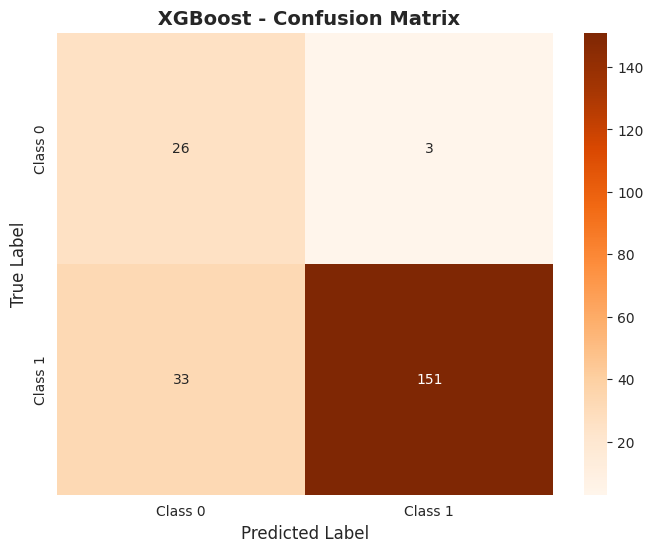

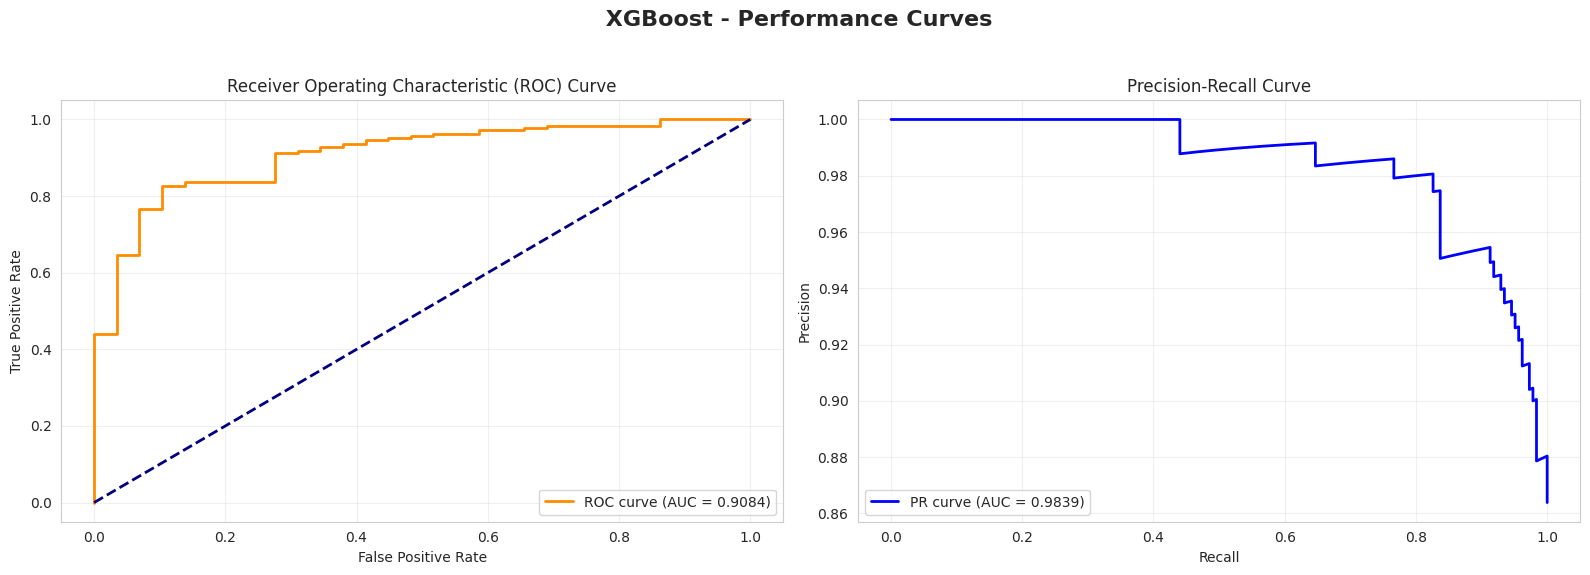

In [ ]:


import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score, 
    f1_score, 
    precision_score, 
    recall_score, 
    roc_auc_score, 
    roc_curve, 
    precision_recall_curve, 
    auc
)


# Calculate scale_pos_weight for handling class imbalance, same as before
counter = Counter(y_train)
scale_pos_weight = counter[0] / counter[1] if counter[1] > 0 else 1

# Define the model
# NOTE: This model is trained on the resampled data
xgboost_standalone = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_estimators=100
)

print("XGBoost model defined.")
print(f"Using scale_pos_weight: {scale_pos_weight:.3f}")


# The boosting models were trained on the feature-selected, resampled data
print("\nTraining XGBoost on the SMOTE-ENN resampled data...")
# NOTE: X_resampled and y_resampled were created in Cell 22
xgboost_standalone.fit(X_resampled, y_resampled)
print("✓ Training complete.")



print("\n" + "="*80)
print("Evaluating XGBoost on the Test Set")
print("="*80)

y_pred_xgb = xgboost_standalone.predict(X_test_selected)
y_pred_proba_xgb = xgboost_standalone.predict_proba(X_test_selected)[:, 1]

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=['Class 0', 'Class 1'], digits=4))

# Detailed Metrics
accuracy = accuracy_score(y_test, y_pred_xgb)
f1_macro = f1_score(y_test, y_pred_xgb, average='macro')
roc_auc = roc_auc_score(y_test, y_pred_proba_xgb)

print(f"\nDetailed Metrics:")
print(f"  - Accuracy: {accuracy:.4f}")
print(f"  - F1 Score (Macro): {f1_macro:.4f}")
print(f"  - ROC AUC Score: {roc_auc:.4f}")

# Per-class metrics
print(f"\n  Class 0 (Abnormal):")
print(f"    - Precision: {precision_score(y_test, y_pred_xgb, pos_label=0):.4f}")
print(f"    - Recall:    {recall_score(y_test, y_pred_xgb, pos_label=0):.4f}")
print(f"\n  Class 1 (Normal):")
print(f"    - Precision: {precision_score(y_test, y_pred_xgb, pos_label=1):.4f}")
print(f"    - Recall:    {recall_score(y_test, y_pred_xgb, pos_label=1):.4f}")



# Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.title(' XGBoost - Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

# ROC and PR Curves
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle(' XGBoost - Performance Curves', fontsize=16, fontweight='bold')

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_xgb)
axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('Receiver Operating Characteristic (ROC) Curve')
axes[0].legend(loc="lower right")
axes[0].grid(True, alpha=0.3)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_xgb)
pr_auc = auc(recall, precision)
axes[1].plot(recall, precision, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:.4f})')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve')
axes[1].legend(loc="lower left")
axes[1].grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

